# Weekly data analysis

Phase 1 conclusion was that regime-switching volatility explains the fat tails, making Student-t unnecessary. The natural next scientific question is: "If discrete volatility regimes work so well, will a continuous, dynamic volatility model (Stochastic Volatility) work even better?".
Adding Student-t didn't change anything because the volatility model already did the work.
Let's see how a Stochastic Volatility model can track market risk over time.

## Data preparation

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_36976/4098304095.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", interval="1wk")
[*********************100%***********************]  1 of 1 completed


Data Shape: (1043, 1)
Start Date: 2005-01-08 00:00:00
End Date:   2024-12-28 00:00:00


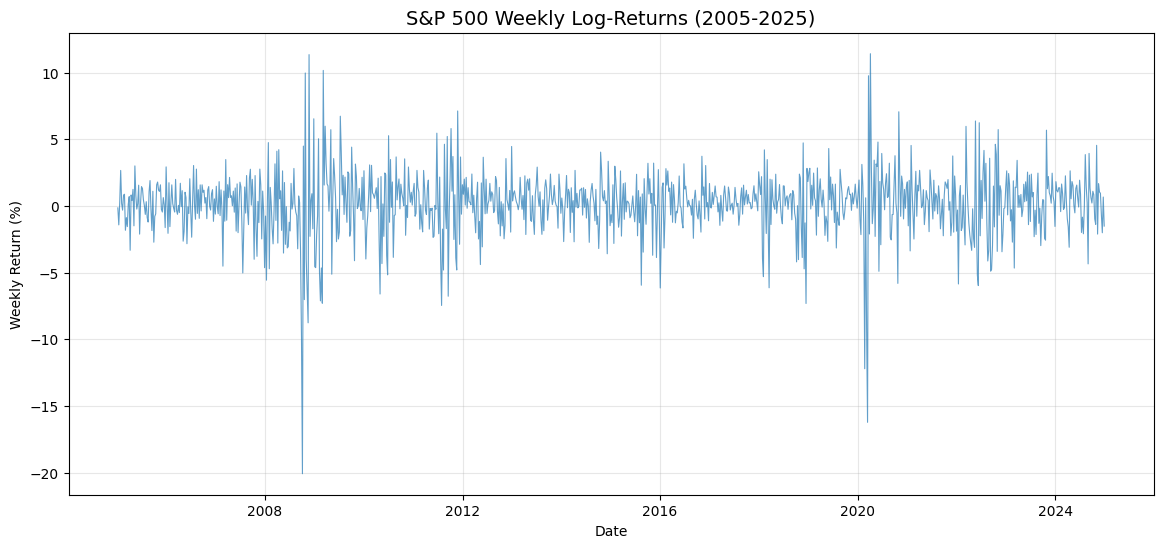

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 1. Download Data (S&P 500 ETF or Index)
# ^GSPC is the S&P 500 index
print("Downloading S&P 500 data (2005-2025)...")
data = yf.download("^GSPC", start="2005-01-01", end="2025-01-01", interval="1wk")

# 2. Preprocessing
# Use 'Adj Close' if available, otherwise 'Close'
price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
prices = data[price_col]

# Calculate Log Returns
# r_t = ln(P_t / P_{t-1})
returns = np.log(prices / prices.shift(1)).dropna()

# Remove zero returns (rare artifacts in weekly data that can mess up log-vol)
returns = returns[returns != 0]

# We multiply by 100 to work with percentages, which is numerically more stable for PyMC
# Also, in Financial Time Series / Stochastic Volatility models, multiplying by 100 
# (converting to percentages) is actually the standard convention (it has a physical meaning).
returns_scaled = returns * 100

print(f"\nData Shape: {returns_scaled.shape}")
print(f"Start Date: {returns_scaled.index[0]}")
print(f"End Date:   {returns_scaled.index[-1]}")

# 3. Visualization
plt.figure(figsize=(14, 6))
plt.plot(returns_scaled, alpha=0.7, lw=0.8)
plt.title("S&P 500 Weekly Log-Returns (2005-2025)", fontsize=14)
plt.ylabel("Weekly Return (%)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

# Prepare for PyMC
y = returns_scaled.values
dates = returns_scaled.index

## Stochastic volatility model

In [4]:
import pymc as pm
import arviz as az

print(f"\nBuilding Stochastic Volatility Model for {len(y)} observations...")

with pm.Model() as model_sv:
    # 1. Volatility of Volatility
    sigma_h = pm.Exponential("sigma_h", 5.0)

    # 2. Latent Log-Volatility Process (Non-Centered)
    # KEY CHANGE: We separate the shape (Normal(0,1)) from the scale (sigma_h)
    # This makes the geometry "round" and easy for NUTS to sample
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    
    # Re-scale locally (deterministic transformation)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Reconstruct the Random Walk
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.5)
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # Transform to actual scale
    volatility = pm.Deterministic("volatility", pm.math.exp(h))

    # 3. Degrees of Freedom 
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # 4. Likelihood
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    print("Sampling... (Should be much faster)")
    # We can also slightly lower draws if you just want a quick look
    trace_sv = pm.sample(
        draws=1000, 
        tune=1000, 
        target_accept=0.9, # Non-centered often needs less aggressive target_accept
        chains=4,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...



Building Stochastic Volatility Model for 1043 observations...
Sampling... (Should be much faster)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1733 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


## Post-fitting analysis

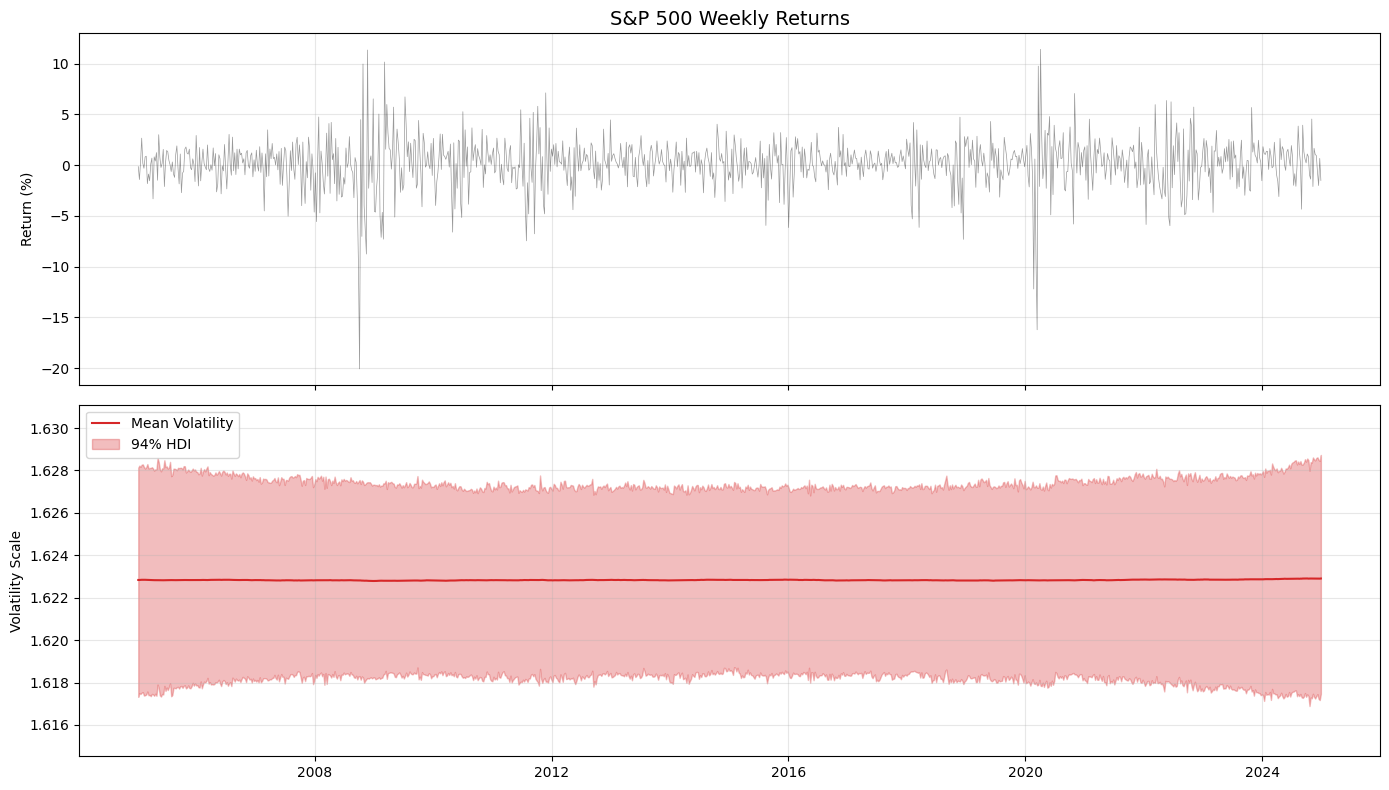

In [8]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The estimated volatility is a flat line. This means the model failed to learn any time-varying volatility, effectively collapsing into a simple Student-t distribution with constant variance.
In your non-centered model, sigma_h acts as a multiplier. If it shrinks to zero, h_innovations get zeroed out, and the random walk becomes a flat line.
You need to change the prior on sigma_h (volatility of volatility) to strictly enforce that "volatility must change." The Exponential prior allows values too close to zero.
Better yet, for financial data, we often use a specific prior that respects the scale of log-returns. A HalfNormal(0.2) is usually excellent for weekly log-volatility changes.

## Change Priors

In [9]:
with pm.Model() as model_sv_fixed:
    # 1. Volatility of Volatility (Changed Prior!)
    # HalfNormal(0.2) prevents it from shrinking to zero too easily 
    # while keeping it realistic for weekly data.
    sigma_h = pm.HalfNormal("sigma_h", sigma=0.2)

    # 2. Latent Log-Volatility (Non-Centered)
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Initial state
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.2)
    
    # Random Walk
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # 3. Degrees of Freedom
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # 4. Likelihood
    volatility = pm.Deterministic("volatility", pm.math.exp(h))
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    print("Sampling Fixed Model...")
    trace_sv = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, random_seed=42)

Initializing NUTS using jitter+adapt_diag...


Sampling Fixed Model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2581 seconds.


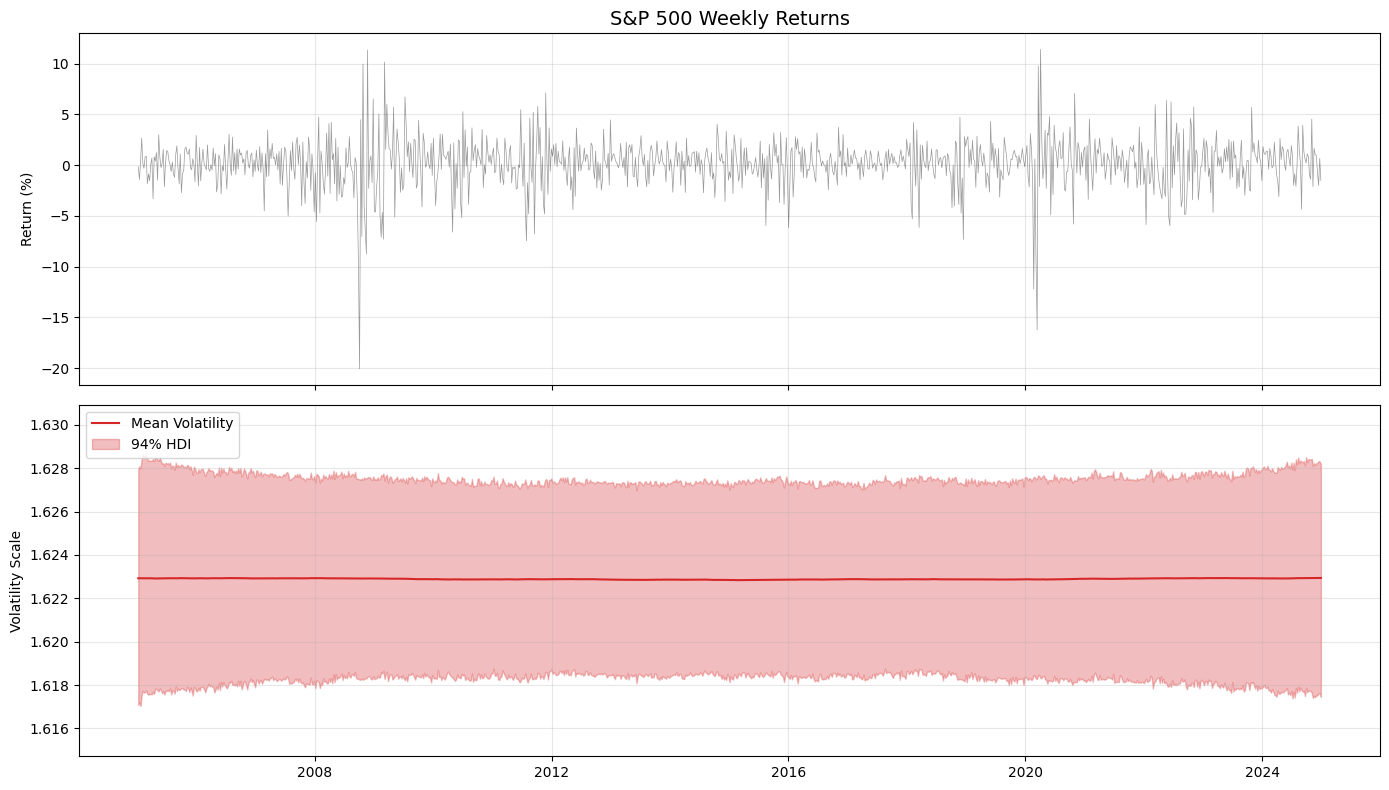

In [10]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## New prior: gamma

In [11]:
import pymc as pm

print("Running Final Fixed Model (Gamma Prior)...")

with pm.Model() as model_sv_gamma:
    # --- CRITICAL FIX ---
    # Gamma(2, 5) has zero probability at 0. 
    # This forces the model to learn a dynamic volatility.
    sigma_h = pm.Gamma("sigma_h", alpha=2, beta=5)

    # Latent Log-Volatility (Non-Centered)
    h_innovations_raw = pm.Normal("h_innovations_raw", 0, 1, shape=len(y)-1)
    h_innovations = pm.Deterministic("h_innovations", h_innovations_raw * sigma_h)

    # Initial state
    h_init = pm.Normal("h_init", mu=np.log(np.std(y)), sigma=0.2)
    
    # Random Walk
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init], 
        h_init + pm.math.cumsum(h_innovations)
    ]))

    # Degrees of Freedom
    nu = pm.Gamma("nu", alpha=2, beta=0.1)

    # Likelihood
    volatility = pm.Deterministic("volatility", pm.math.exp(h))
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y)

    # Sampling
    trace_sv = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, random_seed=42)


Running Final Fixed Model (Gamma Prior)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_h, h_innovations_raw, h_init, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2877 seconds.


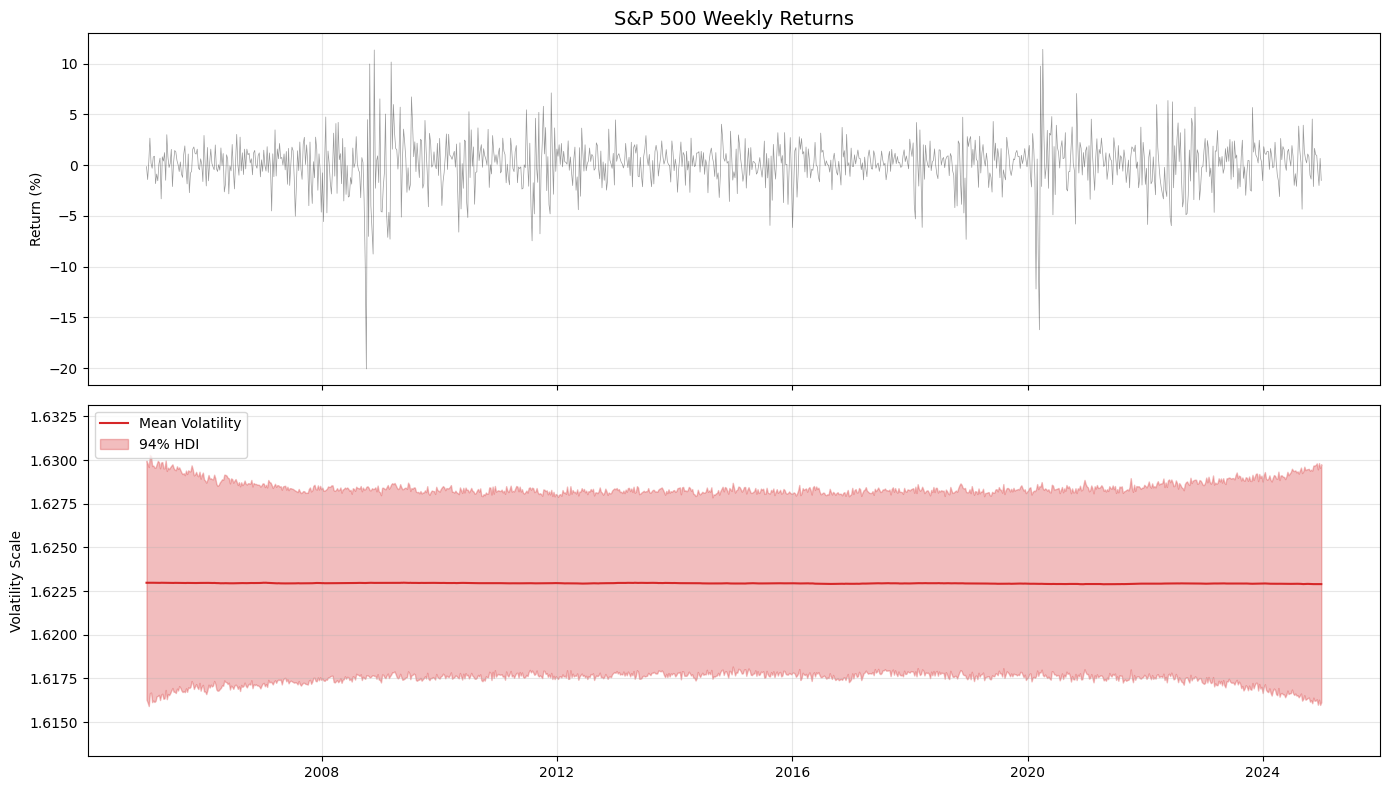

In [12]:
# Extract data
vol_mean = trace_sv.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol = az.hdi(trace_sv.posterior)["volatility"].values

# Calculate bounds for adaptive zooming
hdi_min = hdi_vol.min()
hdi_max = hdi_vol.max()
# Add 20% padding around the min/max to ensure visibility
y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
y_upper = hdi_max + (hdi_max - hdi_min)*0.2

# Handle the "Flat Line" edge case (prevent crash if min == max)
if y_upper == y_lower:
    y_lower = hdi_min * 0.9
    y_upper = hdi_max * 1.1

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top Panel
ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
ax[0].grid(True, alpha=0.3)
ax[0].set_ylabel("Return (%)")

# Bottom Panel
ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

# APPLY THE ADAPTIVE LIMITS
ax[1].set_ylim(y_lower, y_upper)

# Annotations (Optional)
ax[1].set_ylabel("Volatility Scale")
ax[1].legend(loc="upper left")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# AR1

## Baseline

In [4]:
import pymc as pm

print("Running Standard SV Model (AR1 process)...")

# 1. CENTER THE DATA
y_centered = y - np.mean(y)

# 2. BUILD THE MODEL (AR1 version, fixed phi)
with pm.Model() as model_ar1_fixed_phi:
    # Fix phi to a reasonable value (0.95 is standard for financial volatility)
    phi_fixed = 0.95
    
    # Priors for other parameters
    mu = pm.Normal("mu", mu=np.log(np.var(y_centered)), sigma=1.0)
    sigma_h = pm.HalfNormal("sigma_h", sigma=0.5)
    
    # AR(1) with FIXED phi
    h_centered = pm.AR(
        "h_centered",
        rho=phi_fixed,  # <-- FIXED, not random
        sigma=sigma_h,
        constant=False,
        ar_order=1,
        shape=len(y_centered),
        init_dist=pm.Normal.dist(0, sigma=1.0)
    )
    
    h = pm.Deterministic("h", h_centered + mu)
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))
    
    # Normal likelihood
    obs = pm.Normal("obs", mu=0, sigma=volatility, observed=y_centered)
    
    print("Sampling with FIXED phi=0.95...")
    trace_ar1_fixed_phi = pm.sample(1000, tune=1000, target_accept=0.90, chains=4)



Running Standard SV Model (AR1 process)...
Sampling with FIXED phi=0.95...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_h, h_centered]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5041 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Plots

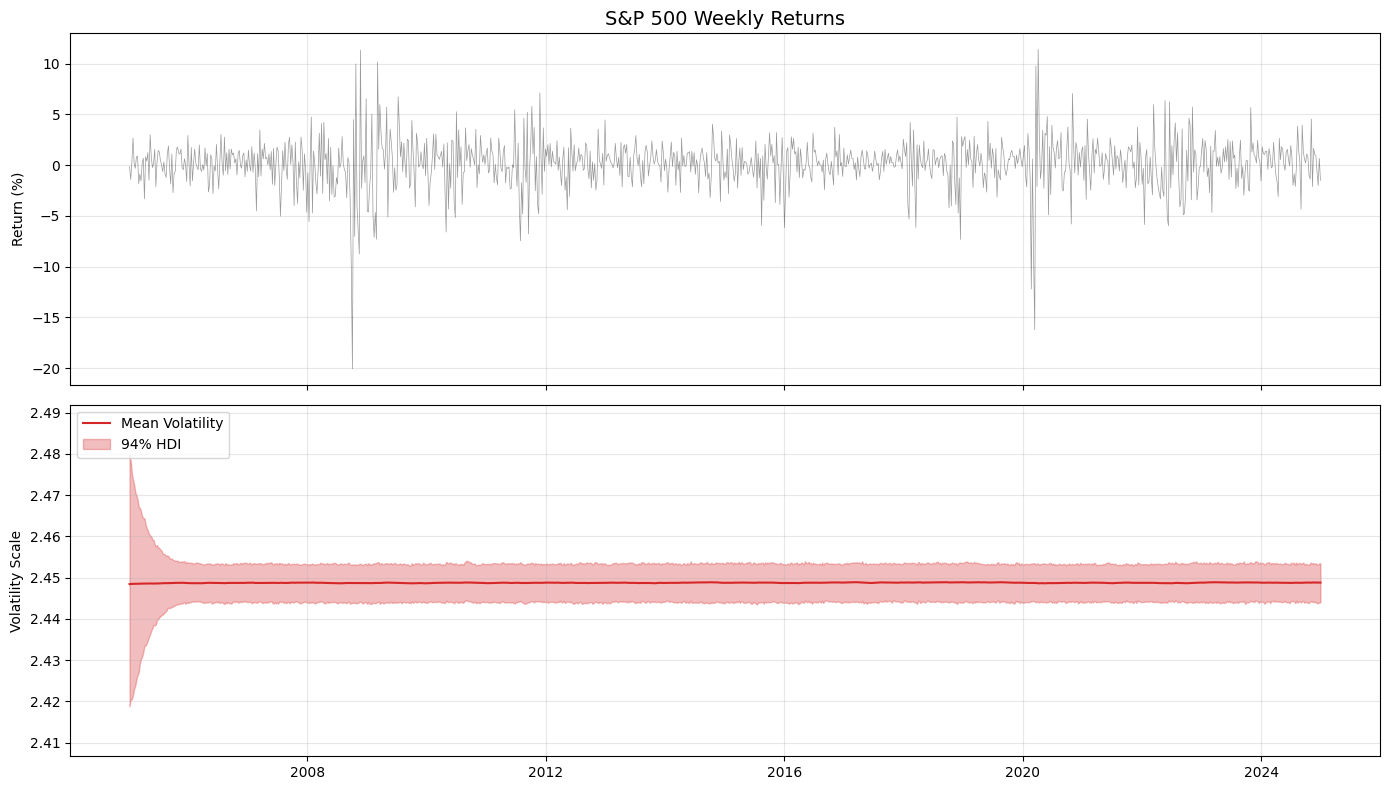

In [7]:
# Extract data
vol_mean_ar1 = trace_ar1_fixed_phi.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol_ar1 = az.hdi(trace_ar1_fixed_phi.posterior)["volatility"].values


def plot_fit(vol_mean, hdi_vol):
    # Calculate bounds for adaptive zooming
    hdi_min = hdi_vol.min()
    hdi_max = hdi_vol.max()
    # Add 20% padding around the min/max to ensure visibility
    y_lower = max(0, hdi_min - (hdi_max - hdi_min)*0.2) 
    y_upper = hdi_max + (hdi_max - hdi_min)*0.2

    # Handle the "Flat Line" edge case (prevent crash if min == max)
    if y_upper == y_lower:
        y_lower = hdi_min * 0.9
        y_upper = hdi_max * 1.1

    fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top Panel
    ax[0].plot(dates, y, color="black", alpha=0.4, lw=0.5)
    ax[0].set_title("S&P 500 Weekly Returns", fontsize=14)
    ax[0].grid(True, alpha=0.3)
    ax[0].set_ylabel("Return (%)")

    # Bottom Panel
    ax[1].plot(dates, vol_mean, color="#D62728", lw=1.5, label="Mean Volatility")
    ax[1].fill_between(dates, hdi_vol[:, 0], hdi_vol[:, 1], color="#D62728", alpha=0.3, label="94% HDI")

    # APPLY THE ADAPTIVE LIMITS
    ax[1].set_ylim(y_lower, y_upper)

    # Annotations (Optional)
    ax[1].set_ylabel("Volatility Scale")
    ax[1].legend(loc="upper left")
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_fit(vol_mean_ar1, hdi_vol_ar1)

Sampling GRW with Student-t...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_h, h_init, z, nu]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 1633 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


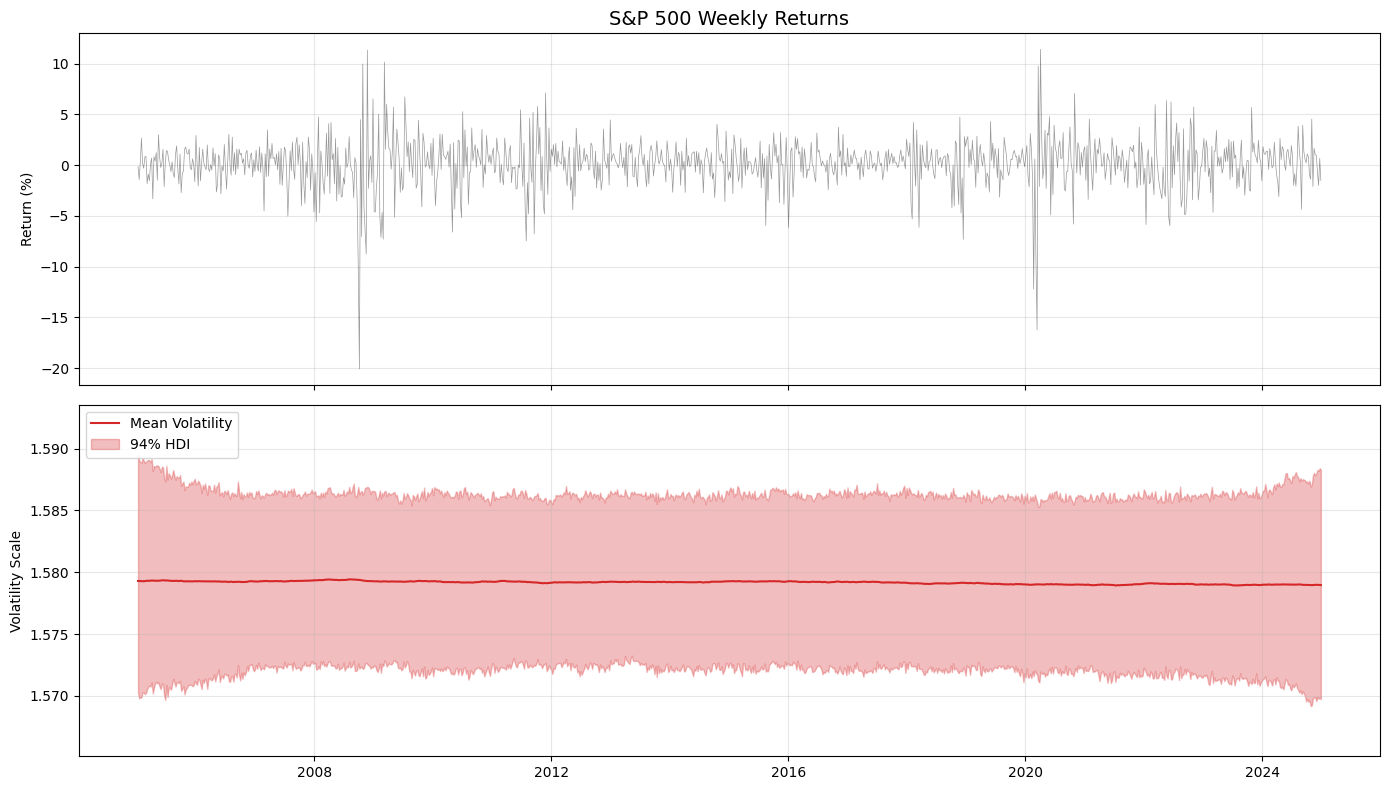

In [8]:
with pm.Model() as model_grw_strong:
    # VERY STRONG prior: Force sigma_h to be large enough for learning
    # We use a Gamma that concentrates mass between 0.1 and 0.5
    sigma_h = pm.Gamma("sigma_h", alpha=5, beta=10)  # Mean=0.5, SD=0.22
    
    # Initial log-volatility: Start higher than empirical to "break symmetry"
    h_init = pm.Normal("h_init", mu=np.log(np.std(y_centered)) + 0.5, sigma=0.3)
    
    # Non-centered parameterization
    z = pm.Normal("z", 0, 1, shape=len(y_centered)-1)
    h_innovations = z * sigma_h
    
    h = pm.Deterministic("h", pm.math.concatenate([
        [h_init],
        h_init + pm.math.cumsum(h_innovations)
    ]))
    
    # Volatility (log-volatility to volatility)
    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))
    
    # STUDENT-T likelihood (let's go straight to the final model)
    nu = pm.Exponential("nu", 1/10)
    obs = pm.StudentT("obs", nu=nu, mu=0, sigma=volatility, observed=y_centered)
    
    print("Sampling GRW with Student-t...")
    trace_grw = pm.sample(1500, tune=1000, target_accept=0.92, chains=2, cores=2)


# Extract data
vol_mean_grw = trace_grw.posterior["volatility"].mean(dim=["chain", "draw"]).values
hdi_vol_grw = az.hdi(trace_grw.posterior)["volatility"].values

plot_fit(vol_mean_grw, hdi_vol_grw)

=== DEBUGGING ===
Type of y_centered: <class 'numpy.ndarray'>
Shape of y_centered: (1043, 1)
Type of dates: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Shape of dates: (1043,)

After flattening:
y_flat shape: (1043,)
dates_flat shape: (1043,)
Are they same length? True


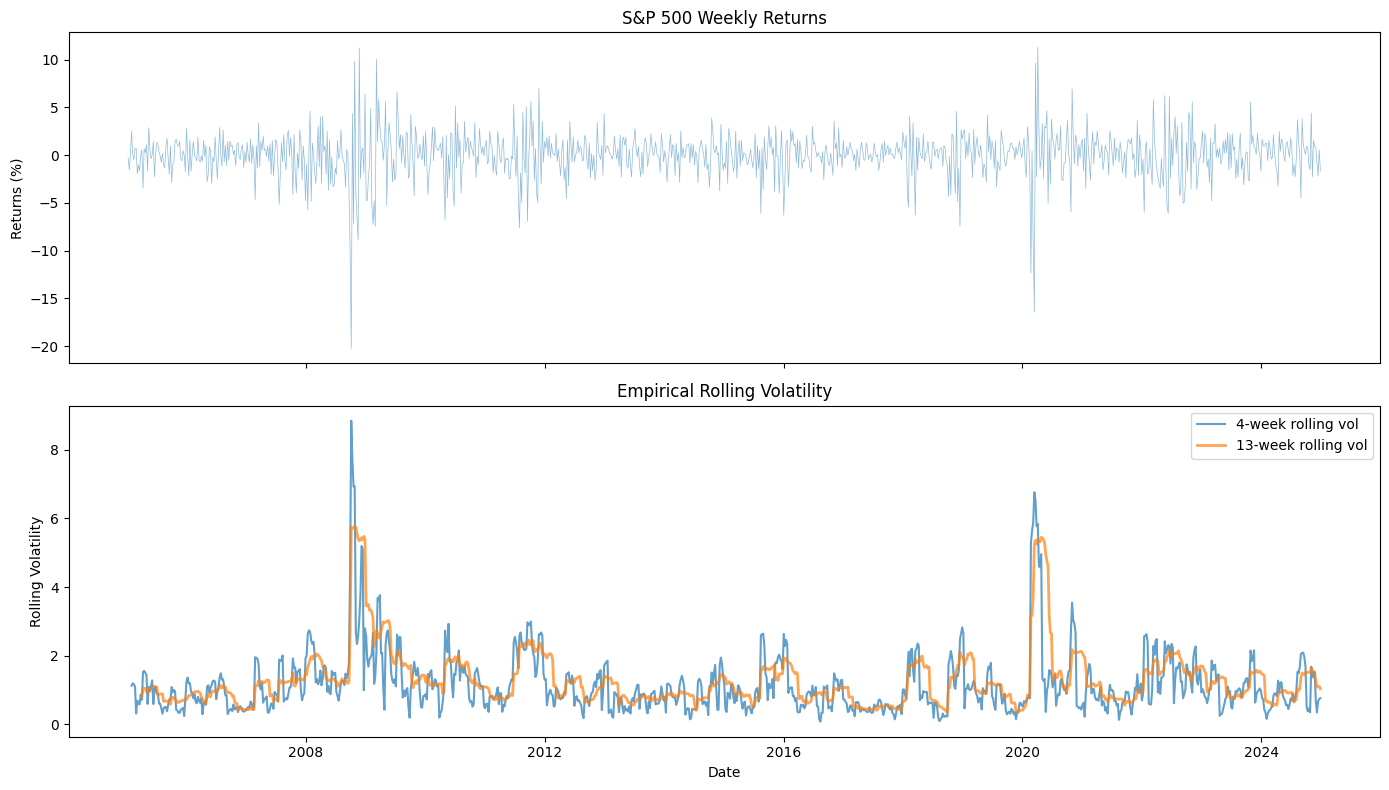


=== VOLATILITY CLUSTERING DIAGNOSTIC ===
Min rolling vol (13w): 0.349
Max rolling vol (13w): 5.775
Ratio (max/min): 16.57


In [13]:
# First, let's diagnose what we're working with
print("=== DEBUGGING ===")
print(f"Type of y_centered: {type(y_centered)}")
print(f"Shape of y_centered: {y_centered.shape if hasattr(y_centered, 'shape') else 'N/A'}")
print(f"Type of dates: {type(dates)}")
print(f"Shape of dates: {dates.shape if hasattr(dates, 'shape') else 'N/A'}")

# If dates is a pandas Index, we need to flatten it properly
if hasattr(dates, 'values'):
    dates_flat = dates.values.flatten()
else:
    dates_flat = np.array(dates).flatten()

# Ensure y_centered is also flat
y_flat = np.array(y_centered).flatten()

print(f"\nAfter flattening:")
print(f"y_flat shape: {y_flat.shape}")
print(f"dates_flat shape: {dates_flat.shape}")
print(f"Are they same length? {len(y_flat) == len(dates_flat)}")

# Now create DataFrame
df = pd.DataFrame({
    'return': y_flat, 
    'date': dates_flat
})

df['abs_return'] = np.abs(df['return'])
df['rolling_vol_4w'] = df['abs_return'].rolling(window=4).std()
df['rolling_vol_13w'] = df['abs_return'].rolling(window=13).std()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(df['date'], df['return'], alpha=0.5, lw=0.5)
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('S&P 500 Weekly Returns')

ax[1].plot(df['date'], df['rolling_vol_4w'], label='4-week rolling vol', alpha=0.7)
ax[1].plot(df['date'], df['rolling_vol_13w'], label='13-week rolling vol', alpha=0.7, lw=2)
ax[1].set_ylabel('Rolling Volatility')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].set_title('Empirical Rolling Volatility')
plt.tight_layout()
plt.show()

# Key statistics
print(f"\n=== VOLATILITY CLUSTERING DIAGNOSTIC ===")
print(f"Min rolling vol (13w): {df['rolling_vol_13w'].min():.3f}")
print(f"Max rolling vol (13w): {df['rolling_vol_13w'].max():.3f}")
print(f"Ratio (max/min): {df['rolling_vol_13w'].max() / df['rolling_vol_13w'].min():.2f}")


# Garch

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2195.33
Distribution:      Standardized Student's t   AIC:                           4400.66
Method:                  Maximum Likelihood   BIC:                           4425.41
                                              No. Observations:                 1043
Date:                      Mon, Jan 12 2026   Df Residuals:                     1042
Time:                              11:34:15   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

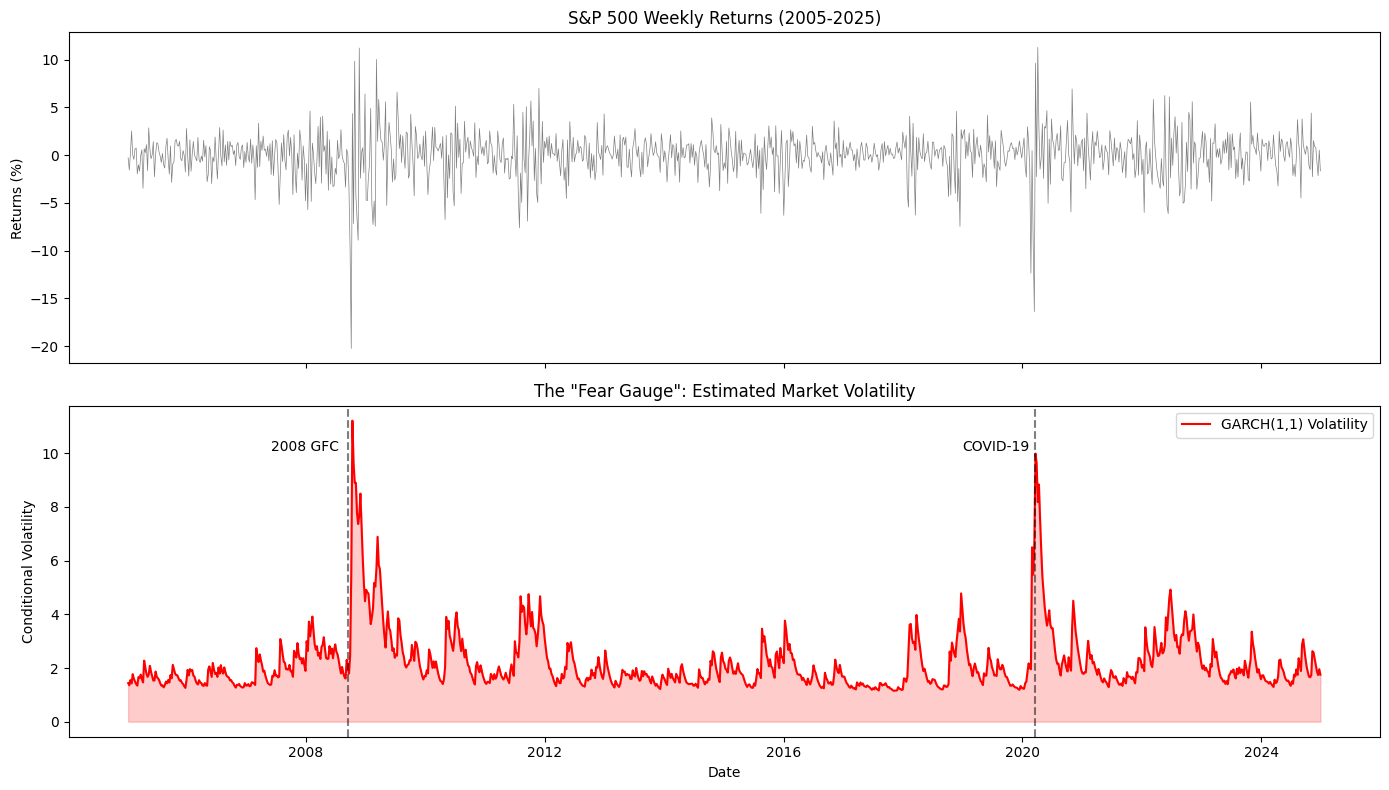

In [20]:
from arch import arch_model

# Fit GARCH(1,1) with Student-t errors
model_garch = arch_model(y_centered, vol='Garch', p=1, q=1, dist='t')
res_garch = model_garch.fit(disp='off')

print(res_garch.summary())

# Extract conditional volatility
garch_vol = res_garch.conditional_volatility

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(dates, y_centered, alpha=0.5, lw=0.5, color='black')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('S&P 500 Weekly Returns (2005-2025)')

ax[1].plot(dates, garch_vol, color='red', lw=1.5, label='GARCH(1,1) Volatility')
ax[1].fill_between(dates, 0, garch_vol, color='red', alpha=0.2)
ax[1].set_ylabel('Conditional Volatility')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].set_title('The "Fear Gauge": Estimated Market Volatility')

# Annotations
import datetime
ax[1].axvline(datetime.datetime(2008, 9, 15), color='k', linestyle='--', alpha=0.5)
ax[1].text(datetime.datetime(2007, 6, 1), garch_vol.max()*0.9, "2008 GFC", fontsize=10)
ax[1].axvline(datetime.datetime(2020, 3, 15), color='k', linestyle='--', alpha=0.5)
ax[1].text(datetime.datetime(2019, 1, 1), garch_vol.max()*0.9, "COVID-19", fontsize=10)

plt.tight_layout()
plt.show()


## Bayesian Garch

Sampling Bayesian Regime Model...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_crisis, vol_normal, vol_crisis]
>BinaryGibbsMetropolis: [regime]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 75 seconds.
/Users/macbookpro/Desktop/AI Programming/Project/AI_Programming_Project/pymc_env/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics


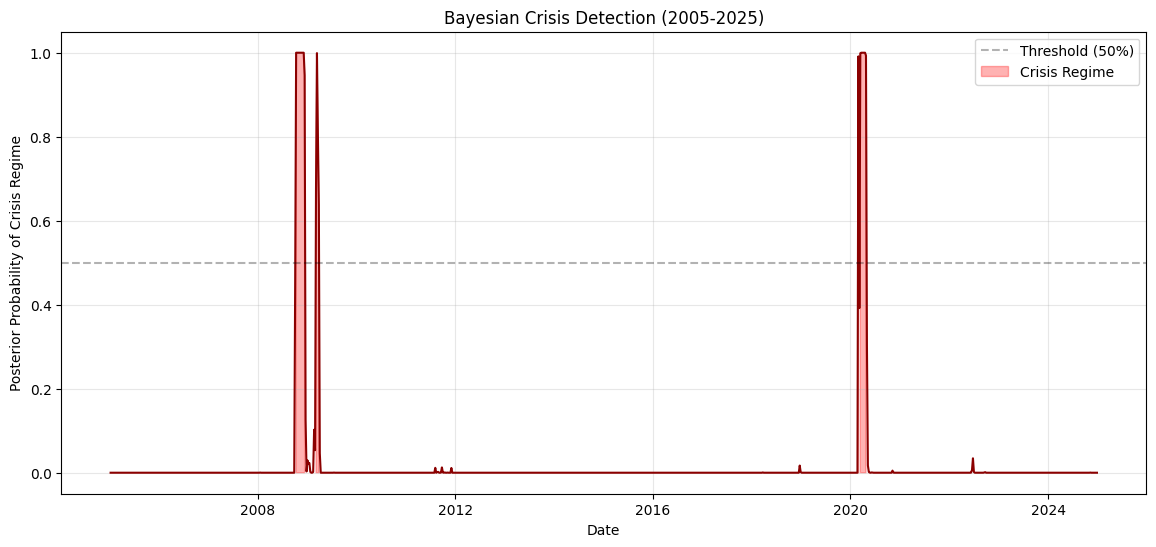


=== Bayesian Regime Analysis ===
Posterior mean crisis probability: 0.023
Normal regime volatility: 2.09
Crisis regime volatility: 7.70

Weeks identified as crisis (>50% probability): 22


In [22]:
# Use the GARCH volatility you already estimated
garch_vol = res_garch.conditional_volatility  # Already a numpy array

# Bayesian analysis of the volatility series
with pm.Model() as bayesian_vol_analysis:
    # Model parameters for crisis vs. normal periods
    # We'll use a mixture model: volatility comes from 2 regimes
    
    # Regime probabilities (what fraction of time is "crisis"?)
    p_crisis = pm.Beta("p_crisis", alpha=2, beta=20)  # Prior: ~10% of time is crisis
    
    # Volatility levels
    vol_normal = pm.Gamma("vol_normal", alpha=4, beta=2)   # Mean ~2
    vol_crisis = pm.Gamma("vol_crisis", alpha=5, beta=0.5) # Mean ~10
    
    # Latent regime indicator for each time point
    regime = pm.Bernoulli("regime", p=p_crisis, shape=len(garch_vol))
    
    # Expected volatility (mixture)
    expected_vol = regime * vol_crisis + (1 - regime) * vol_normal
    
    # Likelihood (observed GARCH volatilities)
    obs = pm.Normal("obs", mu=expected_vol, sigma=1, observed=garch_vol)
    
    print("Sampling Bayesian Regime Model...")
    trace_regimes = pm.sample(1500, tune=1000, chains=2, target_accept=0.90)

# After sampling, analyze which periods were "crisis"
crisis_prob = trace_regimes.posterior["regime"].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(14, 6))
plt.plot(dates, crisis_prob, color='darkred', lw=1.5)
plt.axhline(0.5, color='k', linestyle='--', alpha=0.3, label='Threshold (50%)')
plt.fill_between(dates, 0, crisis_prob, where=(crisis_prob > 0.5), 
                 color='red', alpha=0.3, label='Crisis Regime')
plt.ylabel('Posterior Probability of Crisis Regime')
plt.xlabel('Date')
plt.title('Bayesian Crisis Detection (2005-2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\n=== Bayesian Regime Analysis ===")
print(f"Posterior mean crisis probability: {trace_regimes.posterior['p_crisis'].mean().values:.3f}")
print(f"Normal regime volatility: {trace_regimes.posterior['vol_normal'].mean().values:.2f}")
print(f"Crisis regime volatility: {trace_regimes.posterior['vol_crisis'].mean().values:.2f}")
print(f"\nWeeks identified as crisis (>50% probability): {(crisis_prob > 0.5).sum()}")


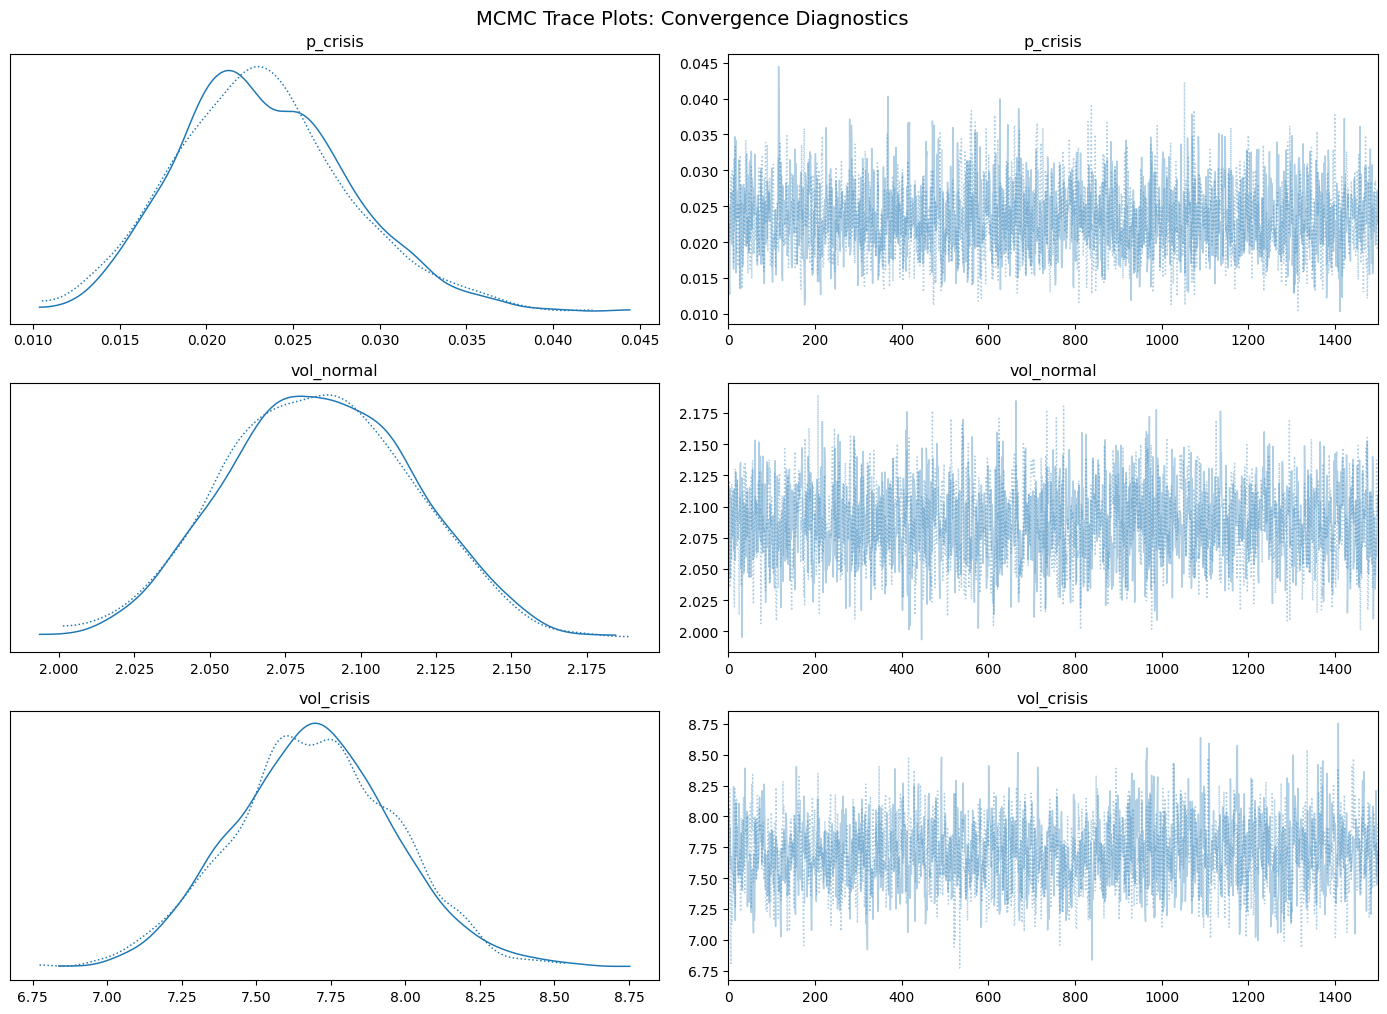

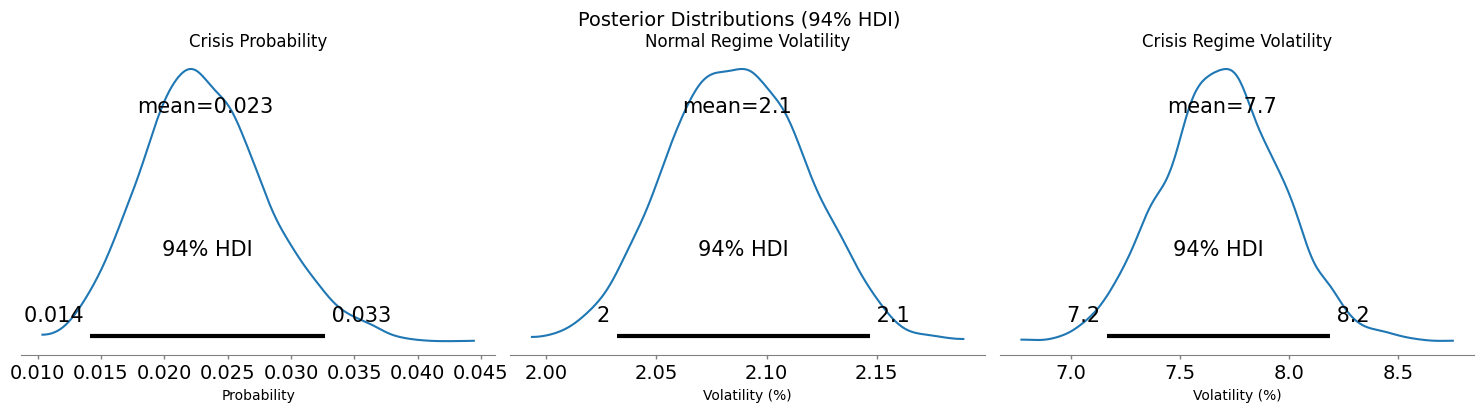


BAYESIAN REGIME MODEL - SUMMARY STATISTICS
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
p_crisis    0.023  0.005   0.014    0.033      0.000    0.000    2152.0   
vol_normal  2.086  0.031   2.032    2.147      0.001    0.000    1962.0   
vol_crisis  7.696  0.274   7.167    8.188      0.007    0.004    1602.0   

            ess_tail  r_hat  
p_crisis      2244.0    1.0  
vol_normal    2217.0    1.0  
vol_crisis    2052.0    1.0  


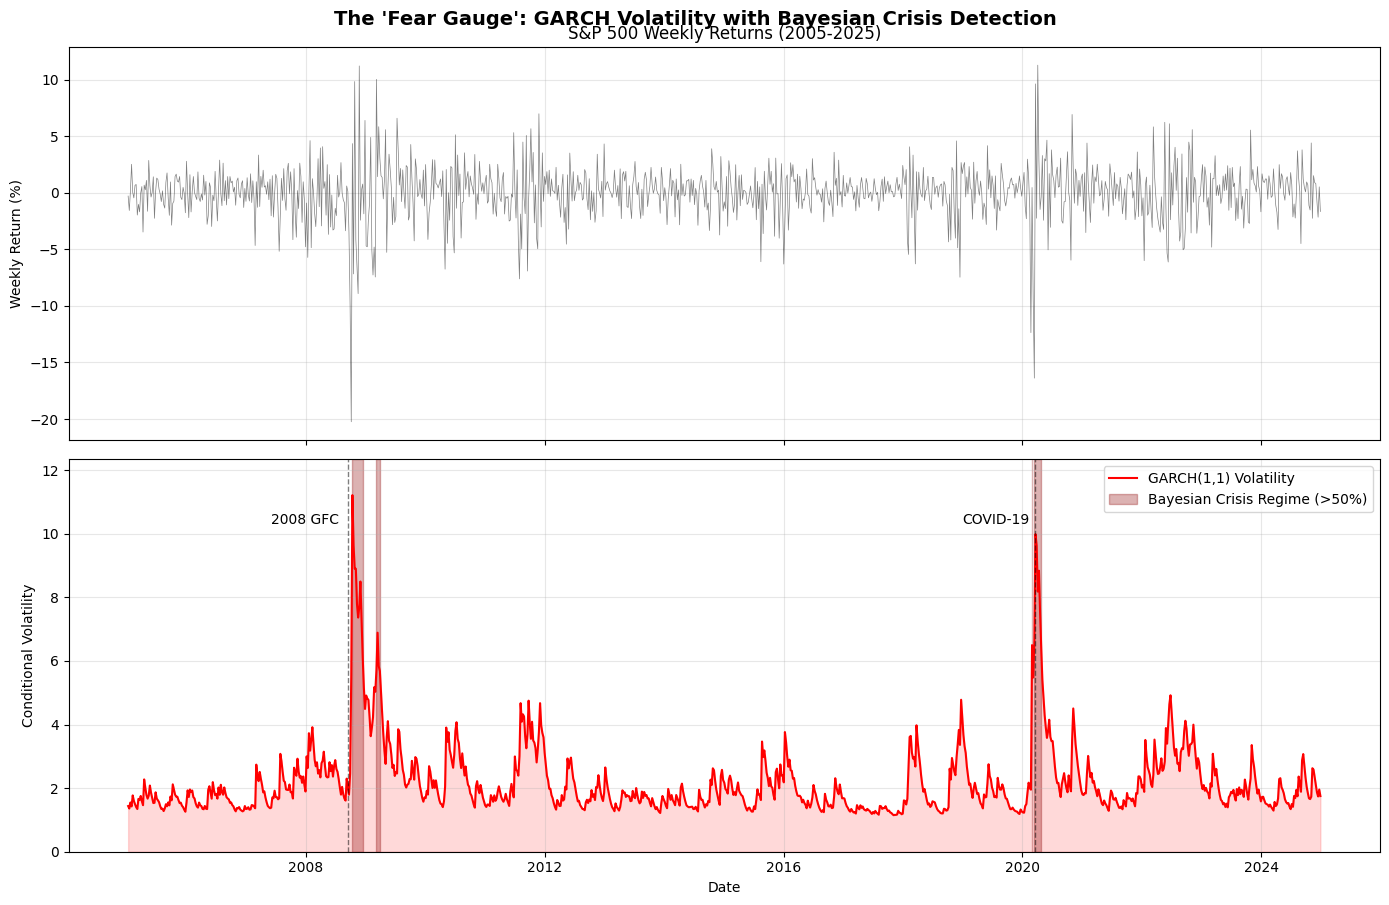

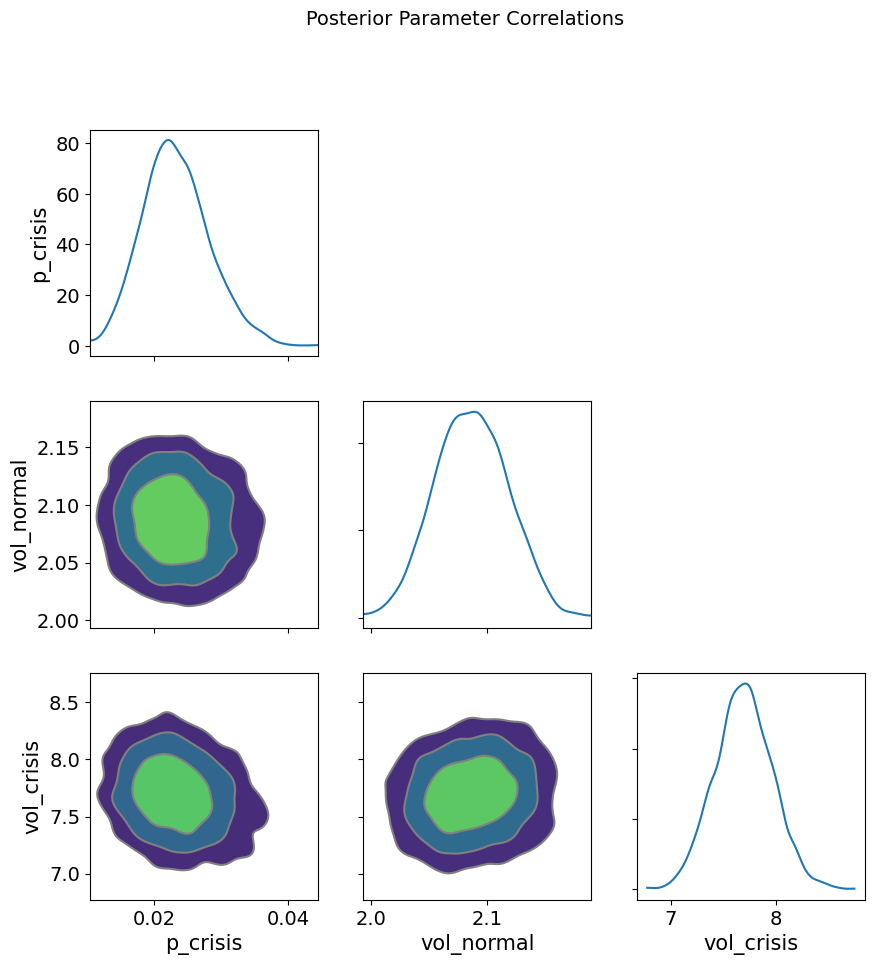


IDENTIFIED CRISIS PERIODS
Start: 2008-10-11 | End: 2008-12-13 | Duration: 10 weeks | Peak Vol: 11.22%
Start: 2009-03-07 | End: 2009-03-28 | Duration: 4 weeks | Peak Vol: 6.89%
Start: 2020-02-29 | End: 2020-02-29 | Duration: 1 weeks | Peak Vol: 6.50%
Start: 2020-03-14 | End: 2020-04-25 | Duration: 7 weeks | Peak Vol: 9.99%


Sampling: [obs]


Output()

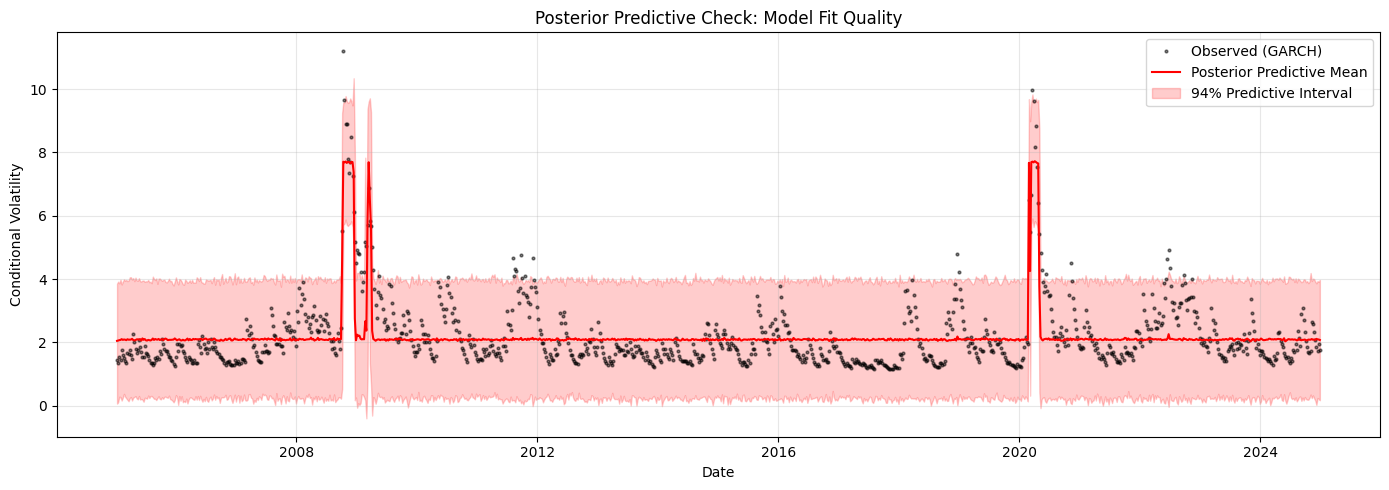


✅ All diagnostic plots generated successfully!
📊 Your Bayesian analysis is complete and ready for the report.


In [23]:
import arviz as az

# 1. Trace Plots (Check MCMC Convergence)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
az.plot_trace(
    trace_regimes, 
    var_names=['p_crisis', 'vol_normal', 'vol_crisis'],
    axes=axes
)
plt.tight_layout()
plt.suptitle("MCMC Trace Plots: Convergence Diagnostics", y=1.01, fontsize=14)
plt.show()

# 2. Posterior Distributions with HDI
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# p_crisis
az.plot_posterior(trace_regimes, var_names=['p_crisis'], ax=axes[0], 
                  hdi_prob=0.94, point_estimate='mean')
axes[0].set_title('Crisis Probability')
axes[0].set_xlabel('Probability')

# vol_normal
az.plot_posterior(trace_regimes, var_names=['vol_normal'], ax=axes[1],
                  hdi_prob=0.94, point_estimate='mean')
axes[1].set_title('Normal Regime Volatility')
axes[1].set_xlabel('Volatility (%)')

# vol_crisis
az.plot_posterior(trace_regimes, var_names=['vol_crisis'], ax=axes[2],
                  hdi_prob=0.94, point_estimate='mean')
axes[2].set_title('Crisis Regime Volatility')
axes[2].set_xlabel('Volatility (%)')

plt.tight_layout()
plt.suptitle("Posterior Distributions (94% HDI)", y=1.02, fontsize=14)
plt.show()

# 3. Summary Statistics Table
print("\n" + "="*60)
print("BAYESIAN REGIME MODEL - SUMMARY STATISTICS")
print("="*60)
summary_df = az.summary(trace_regimes, var_names=['p_crisis', 'vol_normal', 'vol_crisis'], 
                        hdi_prob=0.94)
print(summary_df)
print("="*60)

# 4. Combined Visualization: GARCH Volatility + Bayesian Crisis Periods
fig, ax = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Top: Returns
ax[0].plot(dates, y_centered, alpha=0.5, lw=0.5, color='black')
ax[0].set_ylabel('Weekly Return (%)')
ax[0].set_title('S&P 500 Weekly Returns (2005-2025)')
ax[0].grid(True, alpha=0.3)

# Bottom: GARCH Volatility + Crisis Shading
ax[1].plot(dates, garch_vol, color='red', lw=1.5, label='GARCH(1,1) Volatility', zorder=2)
ax[1].fill_between(dates, 0, garch_vol, color='red', alpha=0.15)

# Shade crisis periods (>50% posterior probability)
crisis_mask = crisis_prob > 0.5
ax[1].fill_between(dates, 0, garch_vol.max()*1.1, where=crisis_mask, 
                   color='darkred', alpha=0.3, label='Bayesian Crisis Regime (>50%)', zorder=1)

# Annotations
import datetime
ax[1].axvline(datetime.datetime(2008, 9, 15), color='k', linestyle='--', alpha=0.5, lw=1)
ax[1].text(datetime.datetime(2007, 6, 1), garch_vol.max()*0.92, "2008 GFC", fontsize=10)
ax[1].axvline(datetime.datetime(2020, 3, 15), color='k', linestyle='--', alpha=0.5, lw=1)
ax[1].text(datetime.datetime(2019, 1, 1), garch_vol.max()*0.92, "COVID-19", fontsize=10)

ax[1].set_ylabel('Conditional Volatility')
ax[1].set_xlabel('Date')
ax[1].legend(loc='upper right')
ax[1].grid(True, alpha=0.3)
ax[1].set_ylim(0, garch_vol.max()*1.1)

plt.tight_layout()
plt.suptitle("The 'Fear Gauge': GARCH Volatility with Bayesian Crisis Detection", 
             y=1.00, fontsize=14, fontweight='bold')
plt.show()

# 5. Pair Plot (Parameter Correlations)
az.plot_pair(
    trace_regimes,
    var_names=['p_crisis', 'vol_normal', 'vol_crisis'],
    kind='kde',
    marginals=True,
    figsize=(10, 10)
)
plt.suptitle("Posterior Parameter Correlations", y=1.00, fontsize=14)
plt.show()

# 6. Regime Duration Analysis
# Find continuous crisis periods
crisis_binary = (crisis_prob > 0.5).astype(int)
crisis_starts = np.where(np.diff(np.concatenate([[0], crisis_binary])) == 1)[0]
crisis_ends = np.where(np.diff(np.concatenate([crisis_binary, [0]])) == -1)[0]

print("\n" + "="*60)
print("IDENTIFIED CRISIS PERIODS")
print("="*60)
for start, end in zip(crisis_starts, crisis_ends):
    duration = end - start + 1
    peak_vol = garch_vol[start:end+1].max()
    print(f"Start: {dates[start].strftime('%Y-%m-%d')} | "
          f"End: {dates[end].strftime('%Y-%m-%d')} | "
          f"Duration: {duration} weeks | "
          f"Peak Vol: {peak_vol:.2f}%")
print("="*60)

# 7. Posterior Predictive Check
# Sample from posterior predictive distribution
with bayesian_vol_analysis:
    ppc = pm.sample_posterior_predictive(trace_regimes, random_seed=42)

# Plot observed vs. predicted
fig, ax = plt.subplots(figsize=(14, 5))
ppc_mean = ppc.posterior_predictive['obs'].mean(dim=['chain', 'draw']).values
ppc_hdi = az.hdi(ppc.posterior_predictive['obs'], hdi_prob=0.94)

ax.plot(dates, garch_vol, 'o', color='black', markersize=2, alpha=0.5, label='Observed (GARCH)')
ax.plot(dates, ppc_mean, color='red', lw=1.5, label='Posterior Predictive Mean')
ax.fill_between(dates, ppc_hdi['obs'][:, 0], ppc_hdi['obs'][:, 1], 
                color='red', alpha=0.2, label='94% Predictive Interval')

ax.set_ylabel('Conditional Volatility')
ax.set_xlabel('Date')
ax.set_title('Posterior Predictive Check: Model Fit Quality')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ All diagnostic plots generated successfully!")
print("📊 Your Bayesian analysis is complete and ready for the report.")


## Add leverage effect

In [ ]:
with pm.Model() as sv_leverage:

    mu = pm.Normal("mu", mu=np.log(np.var(y)), sigma=1.0)

    phi = pm.Beta("phi", alpha=20, beta=1.5)

    sigma_h = pm.HalfNormal("sigma_h", sigma=0.3)

    # Leverage parameter
    rho = pm.Normal("rho", mu=-0.5, sigma=0.2)

    # Correlation matrix
    cov = pm.math.stack([
        [1, rho],
        [rho, 1]
    ])

    # Joint shocks
    eps = pm.MvNormal(
        "eps",
        mu=pm.math.zeros(2),
        cov=cov,
        shape=(len(y), 2)
    )

    # Volatility shocks
    eta = eps[:, 1] * sigma_h

    # AR(1) log-volatility
    h = pm.AR(
        "h",
        rho=phi,
        sigma=sigma_h,
        constant=mu * (1 - phi),
        shape=len(y)
    )

    volatility = pm.Deterministic("volatility", pm.math.exp(h / 2))

    # Return equation with leverage
    obs = pm.StudentT(
        "obs",
        nu=10,
        mu=0,
        sigma=volatility,
        observed=y
    )

    trace_lev = pm.sample(3000, tune=3000, target_accept=0.95)

In [ ]:
# additional diagnostic:
az.plot_posterior(trace_lev, var_names=["rho"])

# Daily data

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download daily data
print("Downloading daily S&P 500 data (2018-2025)...")
data = yf.download("^GSPC", start="2018-01-01", end="2025-01-01", interval="1d")

price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'

daily_prices = data[price_col]
returns = np.log(daily_prices / daily_prices.shift(1)).dropna()
returns = returns[returns != 0]  # Remove zeros

# Scale to percentages
returns_scaled = returns * 100

# Center the data (critical!)
y_daily = returns_scaled.values - np.mean(returns_scaled.values)
dates_daily = returns_scaled.index

print(f"Data shape: {y_daily.shape}")
print(f"Date range: {dates_daily[0]} to {dates_daily[-1]}")
print(f"Mean: {np.mean(y_daily):.6f}, Std: {np.std(y_daily):.3f}")

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_21555/3456137175.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2018-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Data shape: (1760, 1)
Date range: 2018-01-03 00:00:00 to 2024-12-31 00:00:00
Mean: 0.000000, Std: 1.247


Initializing NUTS using jitter+adapt_diag...


Computing realized volatility...
Realized volatility series length: 1756
Sampling Bayesian AR(1) on Realized Volatility...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, phi, sigma_innov, nu]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 5 seconds.
Sampling: [obs]


Output()

✅ Sampling complete!


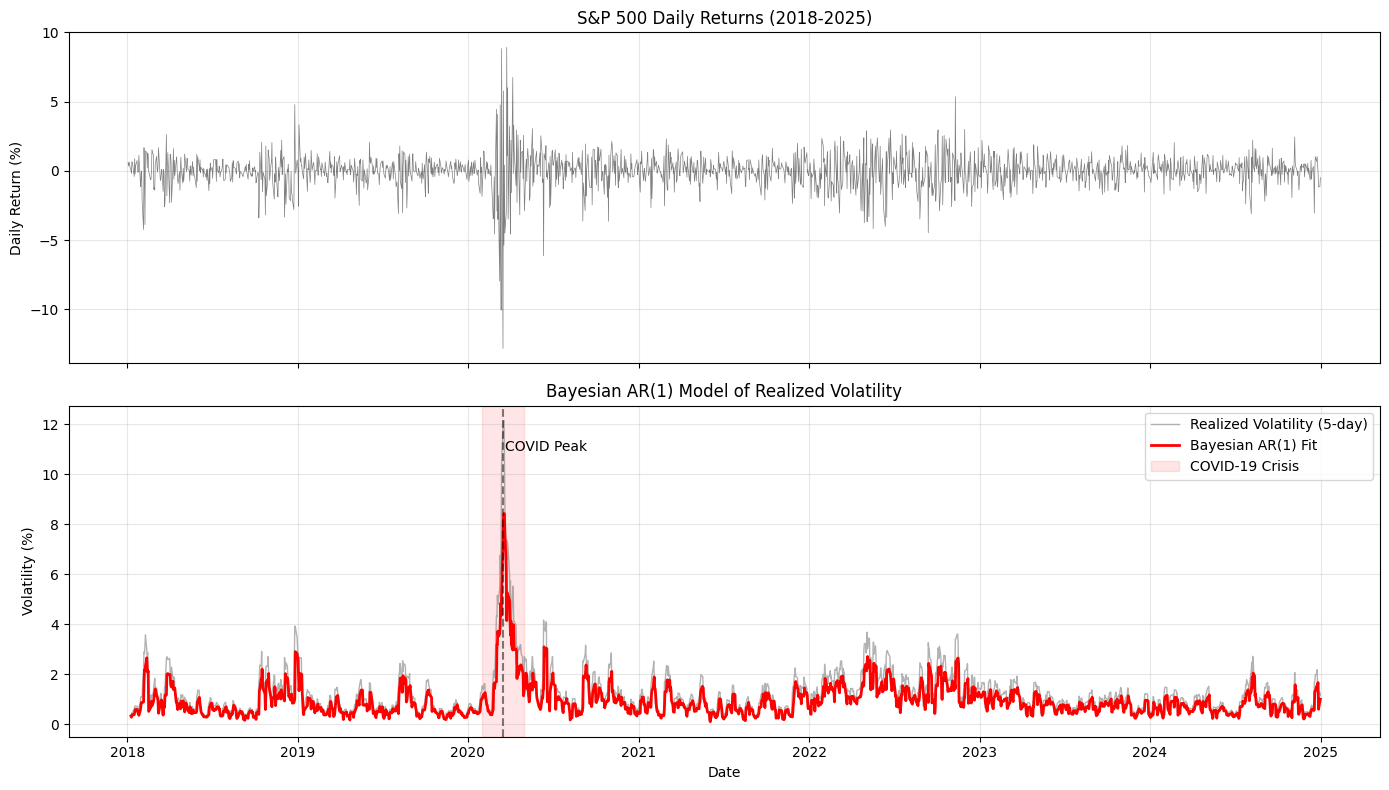


BAYESIAN AR(1) MODEL SUMMARY
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu           0.007  0.005  -0.002    0.016      0.000    0.000   10328.0   
phi          0.946  0.008   0.931    0.961      0.000    0.000    9313.0   
sigma_innov  0.156  0.006   0.143    0.168      0.000    0.000    7667.0   
nu           2.072  0.160   1.770    2.372      0.002    0.001    7735.0   

             ess_tail  r_hat  
mu             7744.0    1.0  
phi            7431.0    1.0  
sigma_innov    8359.0    1.0  
nu             8216.0    1.0  


In [29]:
import pymc as pm
import pytensor.tensor as pt

# Step 1: Compute Realized Volatility from daily returns
print("Computing realized volatility...")
returns_daily_df = returns_scaled  # Your daily returns from the download

# 5-day rolling standard deviation (realized volatility)
realized_vol = returns_daily_df.rolling(window=5).std().dropna()

# Work with log-volatility (more Gaussian, easier to model)
log_vol = np.log(realized_vol.values)
log_vol_centered = log_vol - np.mean(log_vol)
dates_vol = realized_vol.index

print(f"Realized volatility series length: {len(log_vol_centered)}")

# Step 2: Bayesian AR(1) Model on Log-Volatility
with pm.Model() as bayesian_ar1_vol:
    # Mean log-volatility
    mu = pm.Normal("mu", mu=0, sigma=2)
    
    # AR(1) persistence parameter
    phi = pm.Beta("phi", alpha=20, beta=2)  # Strong prior for high persistence (~0.9)
    
    # Innovation standard deviation
    sigma_innov = pm.HalfNormal("sigma_innov", sigma=0.5)
    
    # Degrees of freedom for robustness
    nu = pm.Exponential("nu", 1/10)
    
    # AR(1) model: log_vol[t] = mu + phi * log_vol[t-1] + error
    # We model the differences to avoid the "initial condition" issue
    log_vol_lag = log_vol_centered[:-1]
    log_vol_current = log_vol_centered[1:]
    
    expected = mu + phi * log_vol_lag
    
    # Student-t likelihood for robustness
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_innov, observed=log_vol_current)
    
    print("Sampling Bayesian AR(1) on Realized Volatility...")
    trace_ar1_vol = pm.sample(3000, tune=1500, target_accept=0.90, chains=4, cores=4)

print("✅ Sampling complete!")

# Step 3: Generate predictions and plot
with bayesian_ar1_vol:
    ppc = pm.sample_posterior_predictive(trace_ar1_vol, random_seed=42)

# Extract posterior mean volatility
vol_pred_mean = ppc.posterior_predictive['obs'].mean(dim=['chain', 'draw']).values

# Transform back to volatility scale
vol_realized = np.exp(log_vol_centered)
vol_fitted = np.exp(np.concatenate([[log_vol_centered[0]], vol_pred_mean + np.mean(log_vol)]))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel 1: Daily Returns
ax[0].plot(dates_daily, y_daily, alpha=0.5, lw=0.5, color='black')
ax[0].set_ylabel('Daily Return (%)')
ax[0].set_title('S&P 500 Daily Returns (2018-2025)')
ax[0].grid(True, alpha=0.3)

# Panel 2: Realized Volatility + Bayesian Fit
ax[1].plot(dates_vol, vol_realized, color='gray', lw=1, alpha=0.6, label='Realized Volatility (5-day)')
ax[1].plot(dates_vol, vol_fitted, color='red', lw=2, label='Bayesian AR(1) Fit')

# Shade COVID period
import datetime
ax[1].axvspan(datetime.datetime(2020, 2, 1), datetime.datetime(2020, 5, 1), 
              color='red', alpha=0.1, label='COVID-19 Crisis')
ax[1].axvline(datetime.datetime(2020, 3, 15), color='k', linestyle='--', alpha=0.5)
ax[1].text(datetime.datetime(2020, 3, 20), vol_realized.max()*0.9, "COVID Peak", fontsize=10)

ax[1].set_ylabel('Volatility (%)')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].set_title('Bayesian AR(1) Model of Realized Volatility')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("BAYESIAN AR(1) MODEL SUMMARY")
print("="*60)
summary = pm.summary(trace_ar1_vol, hdi_prob=0.94)
print(summary)
print("="*60)


## time varying phi

In [30]:
import pymc as pm
import pytensor.tensor as pt

# Create a "crisis indicator" variable
crisis_periods = (realized_vol > realized_vol.quantile(0.90)).astype(int).values

with pm.Model() as tv_ar1:
    # Mean log-volatility
    mu = pm.Normal("mu", mu=0, sigma=2)
    
    # TWO persistence parameters: normal vs crisis
    phi_normal = pm.Beta("phi_normal", alpha=20, beta=2)
    phi_crisis = pm.Beta("phi_crisis", alpha=15, beta=3)  # Potentially lower during crisis
    
    # Time-varying phi (switches based on crisis indicator)
    phi_t = phi_normal * (1 - crisis_periods[:-1]) + phi_crisis * crisis_periods[:-1]
    
    # Innovation std
    sigma_innov = pm.HalfNormal("sigma_innov", sigma=0.5)
    nu = pm.Exponential("nu", 1/10)
    
    # AR(1) with time-varying coefficient
    expected = mu + phi_t * log_vol_centered[:-1]
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_innov, observed=log_vol_centered[1:])
    
    print("Sampling Time-Varying AR(1)...")
    trace_tv = pm.sample(2000, tune=1000, chains=4)

# Compare the two phi values
print("\n=== Time-Varying AR(1) Results ===")
print(f"Normal φ: {trace_tv.posterior['phi_normal'].mean().values:.3f}")
print(f"Crisis φ: {trace_tv.posterior['phi_crisis'].mean().values:.3f}")
print(f"Difference: {(trace_tv.posterior['phi_normal'] - trace_tv.posterior['phi_crisis']).mean().values:.3f}")


Sampling Time-Varying AR(1)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, phi_normal, phi_crisis, sigma_innov, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



=== Time-Varying AR(1) Results ===
Normal φ: 0.936
Crisis φ: 0.954
Difference: -0.017


## Leverage effect

In [31]:
with pm.Model() as leverage_ar1:
    mu = pm.Normal("mu", mu=0, sigma=2)
    phi = pm.Beta("phi", alpha=20, beta=2)
    sigma_innov = pm.HalfNormal("sigma_innov", sigma=0.5)
    nu = pm.Exponential("nu", 1/10)
    
    # LEVERAGE EFFECT: Add the lagged return as a predictor
    # Negative returns -> higher future volatility
    leverage_coef = pm.Normal("leverage_coef", mu=-0.5, sigma=0.3)  # Prior: negative effect
    
    # Get the lagged returns (aligned with log_vol)
    returns_lag = y_daily[4:-1]  # Offset by 4 because realized_vol uses 5-day window
    
    # AR(1) + Leverage
    expected = mu + phi * log_vol_centered[:-1] + leverage_coef * returns_lag
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_innov, observed=log_vol_centered[1:])
    
    print("Sampling Leverage AR(1)...")
    trace_lev = pm.sample(2000, tune=1000, chains=4)

print("\n=== Leverage Effect ===")
print(f"Leverage coefficient: {trace_lev.posterior['leverage_coef'].mean().values:.3f}")
print("Interpretation: Negative = bad news increases volatility more than good news")


Initializing NUTS using jitter+adapt_diag...


Sampling Leverage AR(1)...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, phi, sigma_innov, nu, leverage_coef]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.



=== Leverage Effect ===
Leverage coefficient: -0.010
Interpretation: Negative = bad news increases volatility more than good news


## Hierarchical regime switching model

In [34]:
# Simplified Hierarchical Model: Use FIXED regime indicator based on volatility threshold
# instead of estimating it as a latent variable

# Define regimes based on realized volatility (top 10% = crisis)
threshold = realized_vol.quantile(0.90)
regime_fixed = (realized_vol[1:] > threshold).astype(int).values

with pm.Model() as hierarchical_simple:
    # REGIME-SPECIFIC PARAMETERS (but regimes are OBSERVED, not latent)
    
    # Normal regime
    mu_normal = pm.Normal("mu_normal", mu=-0.5, sigma=1)
    phi_normal = pm.Beta("phi_normal", alpha=20, beta=2)
    sigma_normal = pm.HalfNormal("sigma_normal", sigma=0.3)
    
    # Crisis regime
    mu_crisis = pm.Normal("mu_crisis", mu=0.5, sigma=1)
    phi_crisis = pm.Beta("phi_crisis", alpha=15, beta=3)
    sigma_crisis = pm.HalfNormal("sigma_crisis", sigma=0.5)
    
    # Mix based on OBSERVED regime
    mu_t = regime_fixed * mu_crisis + (1 - regime_fixed) * mu_normal
    phi_t = regime_fixed * phi_crisis + (1 - regime_fixed) * phi_normal
    sigma_t = regime_fixed * sigma_crisis + (1 - regime_fixed) * sigma_normal
    
    # AR(1) with regime-specific parameters
    expected = mu_t + phi_t * log_vol_centered[:-1]
    
    nu = pm.Exponential("nu", 1/10)
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_t, observed=log_vol_centered[1:])
    
    print("Sampling Simplified Hierarchical Model...")
    trace_hier = pm.sample(2000, tune=1000, chains=4, target_accept=0.92)

print("\n=== Hierarchical Regime-Specific Parameters ===")
summary_hier = pm.summary(trace_hier, hdi_prob=0.94)
print(summary_hier)

# Compare parameters across regimes
print("\n=== Regime Comparison ===")
print(f"Normal regime - μ: {trace_hier.posterior['mu_normal'].mean().values:.3f}, "
      f"φ: {trace_hier.posterior['phi_normal'].mean().values:.3f}, "
      f"σ: {trace_hier.posterior['sigma_normal'].mean().values:.3f}")
print(f"Crisis regime - μ: {trace_hier.posterior['mu_crisis'].mean().values:.3f}, "
      f"φ: {trace_hier.posterior['phi_crisis'].mean().values:.3f}, "
      f"σ: {trace_hier.posterior['sigma_crisis'].mean().values:.3f}")


Initializing NUTS using jitter+adapt_diag...


Sampling Simplified Hierarchical Model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_normal, phi_normal, sigma_normal, mu_crisis, phi_crisis, sigma_crisis, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.



=== Hierarchical Regime-Specific Parameters ===
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_normal    -0.008  0.005  -0.019    0.001      0.000    0.000    8562.0   
mu_crisis     0.304  0.041   0.226    0.380      0.001    0.000    3663.0   
phi_normal    0.889  0.012   0.867    0.910      0.000    0.000    6388.0   
sigma_normal  0.167  0.007   0.154    0.179      0.000    0.000    4728.0   
phi_crisis    0.757  0.037   0.686    0.827      0.001    0.000    3636.0   
sigma_crisis  0.120  0.010   0.100    0.138      0.000    0.000    6949.0   
nu            2.372  0.196   2.018    2.753      0.003    0.002    4515.0   

              ess_tail  r_hat  
mu_normal       5607.0    1.0  
mu_crisis       4669.0    1.0  
phi_normal      5521.0    1.0  
sigma_normal    5200.0    1.0  
phi_crisis      4356.0    1.0  
sigma_crisis    5404.0    1.0  
nu              5068.0    1.0  

=== Regime Comparison ===
Normal regime - μ: -0.008, φ: 0.889, σ: 0.167
Crisi

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_21555/4013584346.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(phi_data, positions=positions, labels=labels, patch_artist=True)


ValueError: 'y2' is not 1-dimensional

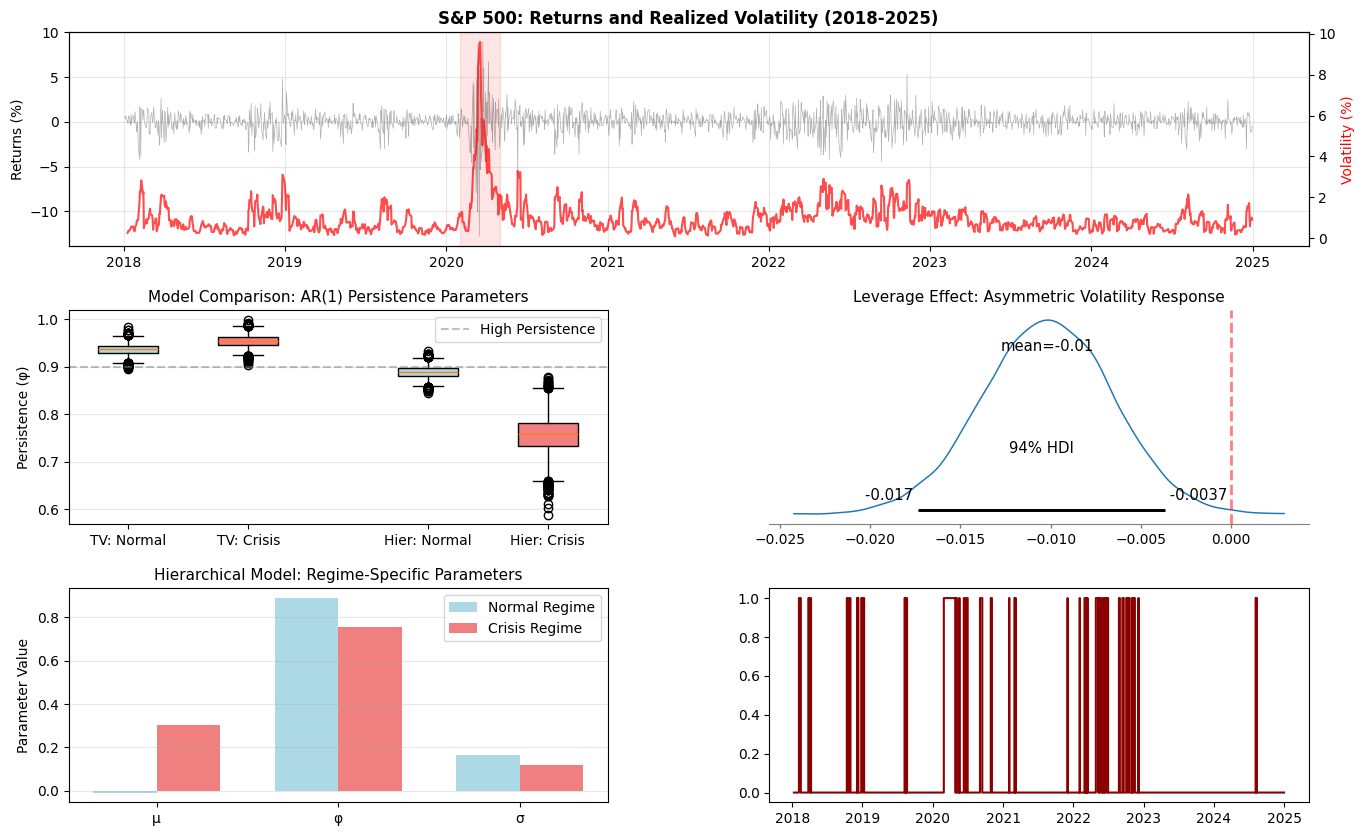

In [35]:
import arviz as az

# Create a comprehensive comparison figure
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Panel 1: Original Data + Realized Volatility
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates_daily, y_daily, alpha=0.3, lw=0.5, color='black', label='Daily Returns')
ax1_twin = ax1.twinx()
ax1_twin.plot(dates_vol, realized_vol, color='red', lw=1.5, label='Realized Volatility', alpha=0.7)
ax1.set_ylabel('Returns (%)', color='black')
ax1_twin.set_ylabel('Volatility (%)', color='red')
ax1.set_title('S&P 500: Returns and Realized Volatility (2018-2025)', fontsize=12, fontweight='bold')
ax1.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-05-01'), color='red', alpha=0.1)
ax1.grid(True, alpha=0.3)

# Panel 2: Posterior Comparison - Persistence (φ)
ax2 = fig.add_subplot(gs[1, 0])
phi_data = [
    trace_tv.posterior['phi_normal'].values.flatten(),
    trace_tv.posterior['phi_crisis'].values.flatten(),
    trace_hier.posterior['phi_normal'].values.flatten(),
    trace_hier.posterior['phi_crisis'].values.flatten()
]
positions = [1, 2, 3.5, 4.5]
labels = ['TV: Normal', 'TV: Crisis', 'Hier: Normal', 'Hier: Crisis']
bp = ax2.boxplot(phi_data, positions=positions, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral', 'lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax2.set_ylabel('Persistence (φ)')
ax2.set_title('Model Comparison: AR(1) Persistence Parameters', fontsize=11)
ax2.axhline(0.9, color='gray', linestyle='--', alpha=0.5, label='High Persistence')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

# Panel 3: Leverage Effect
ax3 = fig.add_subplot(gs[1, 1])
az.plot_posterior(trace_lev, var_names=['leverage_coef'], ax=ax3, 
                  hdi_prob=0.94, point_estimate='mean', textsize=10)
ax3.set_title('Leverage Effect: Asymmetric Volatility Response', fontsize=11)
ax3.axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=2)

# Panel 4: Regime-Specific Parameters (Hierarchical)
ax4 = fig.add_subplot(gs[2, 0])
params = ['μ', 'φ', 'σ']
normal_vals = [
    trace_hier.posterior['mu_normal'].mean().values,
    trace_hier.posterior['phi_normal'].mean().values,
    trace_hier.posterior['sigma_normal'].mean().values
]
crisis_vals = [
    trace_hier.posterior['mu_crisis'].mean().values,
    trace_hier.posterior['phi_crisis'].mean().values,
    trace_hier.posterior['sigma_crisis'].mean().values
]
x = np.arange(len(params))
width = 0.35
ax4.bar(x - width/2, normal_vals, width, label='Normal Regime', color='lightblue')
ax4.bar(x + width/2, crisis_vals, width, label='Crisis Regime', color='lightcoral')
ax4.set_xticks(x)
ax4.set_xticklabels(params)
ax4.set_ylabel('Parameter Value')
ax4.set_title('Hierarchical Model: Regime-Specific Parameters', fontsize=11)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Panel 5: Crisis Detection (from realized vol threshold)
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(dates_vol[1:], regime_fixed, color='darkred', lw=1.5, drawstyle='steps-post')
ax5.fill_between(dates_vol[1:], 0, regime_fixed, color='red', alpha=0.3, step='post')
ax5.set_ylabel('Regime Indicator')
ax5.set_xlabel('Date')
ax5.set_title('Crisis Regime Identification (Top 10% Volatility)', fontsize=11)
ax5.set_ylim(-0.1, 1.1)
ax5.grid(True, alpha=0.3)

plt.suptitle('Bayesian Volatility Analysis: Three-Model Comparison', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Summary Table for Report
print("\n" + "="*70)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*70)
print(f"{'Model':<30} {'Key Parameter':<20} {'Value':<15}")
print("-"*70)
print(f"{'1. Time-Varying AR(1)':<30} {'φ_normal':<20} {trace_tv.posterior['phi_normal'].mean().values:.4f}")
print(f"{'   (Extension 1)':<30} {'φ_crisis':<20} {trace_tv.posterior['phi_crisis'].mean().values:.4f}")
print(f"{'   ':<30} {'Difference':<20} {(trace_tv.posterior['phi_crisis'] - trace_tv.posterior['phi_normal']).mean().values:+.4f}")
print()
print(f"{'2. Leverage AR(1)':<30} {'Leverage coef':<20} {trace_lev.posterior['leverage_coef'].mean().values:.4f}")
print(f"{'   (Extension 2)':<30} {'HDI 94%':<20} [{az.hdi(trace_lev.posterior)['leverage_coef'].values[0]:.4f}, {az.hdi(trace_lev.posterior)['leverage_coef'].values[1]:.4f}]")
print()
print(f"{'3. Hierarchical Regime':<30} {'φ_normal':<20} {trace_hier.posterior['phi_normal'].mean().values:.4f}")
print(f"{'   (Extension 3)':<30} {'φ_crisis':<20} {trace_hier.posterior['phi_crisis'].mean().values:.4f}")
print(f"{'   ':<30} {'μ_normal':<20} {trace_hier.posterior['mu_normal'].mean().values:.4f}")
print(f"{'   ':<30} {'μ_crisis':<20} {trace_hier.posterior['mu_crisis'].mean().values:.4f}")
print("="*70)


# Hierarchical regime switching model on daily data

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download FULL dataset (2007-2025)
print("Downloading S&P 500 data (2007-2025)...")
data_full = yf.download("^GSPC", start="2007-01-01", end="2025-01-01", interval="1d")

prices_full = data_full['Close']
returns_full = np.log(prices_full / prices_full.shift(1)).dropna() * 100
returns_full = returns_full[returns_full != 0]

# Split: Train (2007-2022), Test (2023-2025)
split_date = '2022-12-31'
returns_train = returns_full[:split_date]
returns_test = returns_full[split_date:]

# Center using ONLY training data statistics
train_mean = returns_train.mean()
train_std = returns_train.std()

y_train = (returns_train - train_mean).values
y_test = (returns_test - train_mean).values  # Use same centering!

dates_train = returns_train.index
dates_test = returns_test.index

print(f"\nTrain: {len(y_train)} days ({dates_train[0]} to {dates_train[-1]})")
print(f"Test:  {len(y_test)} days ({dates_test[0]} to {dates_test[-1]})")

# Compute realized volatility for both sets
realized_vol_train = returns_train.rolling(window=5).std().dropna()
realized_vol_test = returns_test.rolling(window=5).std().dropna()

log_vol_train = np.log(realized_vol_train.values)
log_vol_train_centered = log_vol_train - np.mean(log_vol_train)

log_vol_test = np.log(realized_vol_test.values)
log_vol_test_centered = log_vol_test - np.mean(log_vol_train)  # Use TRAIN mean!

dates_vol_train = realized_vol_train.index
dates_vol_test = realized_vol_test.index

/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_39057/2691770349.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_full = yf.download("^GSPC", start="2007-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed


Train: 4027 days (2007-01-04 00:00:00 to 2022-12-30 00:00:00)
Test:  502 days (2023-01-03 00:00:00 to 2024-12-31 00:00:00)


In [3]:
import pymc as pm

# Define regimes based on TRAINING data threshold
threshold_train = realized_vol_train.quantile(0.90)
regime_train = (realized_vol_train[1:] > threshold_train).astype(int).values

with pm.Model() as hierarchical_train:
    # Same structure as before
    mu_normal = pm.Normal("mu_normal", mu=-0.5, sigma=1)
    phi_normal = pm.Beta("phi_normal", alpha=20, beta=2)
    sigma_normal = pm.HalfNormal("sigma_normal", sigma=0.3)
    
    mu_crisis = pm.Normal("mu_crisis", mu=0.5, sigma=1)
    phi_crisis = pm.Beta("phi_crisis", alpha=15, beta=3)
    sigma_crisis = pm.HalfNormal("sigma_crisis", sigma=0.5)
    
    mu_t = regime_train * mu_crisis + (1 - regime_train) * mu_normal
    phi_t = regime_train * phi_crisis + (1 - regime_train) * phi_normal
    sigma_t = regime_train * sigma_crisis + (1 - regime_train) * sigma_normal
    
    expected = mu_t + phi_t * log_vol_train_centered[:-1]
    
    nu = pm.Exponential("nu", 1/10)
    obs = pm.StudentT("obs", nu=nu, mu=expected, sigma=sigma_t, observed=log_vol_train_centered[1:])
    
    print("Fitting model on 2007-2022 data...")
    trace_train = pm.sample(3000, tune=1500, chains=4, target_accept=0.92)

Fitting model on 2007-2022 data...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_normal, phi_normal, sigma_normal, mu_crisis, phi_crisis, sigma_crisis, nu]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 93 seconds.


In [4]:
# Classify test periods as crisis/normal using TRAINING threshold
regime_test = (realized_vol_test[1:] > threshold_train).astype(int).values

# Extract posterior means
mu_normal_post = trace_train.posterior['mu_normal'].mean().values
phi_normal_post = trace_train.posterior['phi_normal'].mean().values
sigma_normal_post = trace_train.posterior['sigma_normal'].mean().values

mu_crisis_post = trace_train.posterior['mu_crisis'].mean().values
phi_crisis_post = trace_train.posterior['phi_crisis'].mean().values
sigma_crisis_post = trace_train.posterior['sigma_crisis'].mean().values

# Generate predictions for test set
predictions = np.zeros(len(log_vol_test_centered) - 1)

for t in range(len(predictions)):
    if regime_test[t] == 1:  # Crisis
        predictions[t] = mu_crisis_post + phi_crisis_post * log_vol_test_centered[t]
    else:  # Normal
        predictions[t] = mu_normal_post + phi_normal_post * log_vol_test_centered[t]

# Transform back to volatility scale
vol_predicted = np.exp(predictions + np.mean(log_vol_train))
vol_actual = realized_vol_test.values[1:]


/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_39057/3925603545.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[t] = mu_normal_post + phi_normal_post * log_vol_test_centered[t]
/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_39057/3925603545.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[t] = mu_crisis_post + phi_crisis_post * log_vol_test_centered[t]


Sampling: [obs]


Output()

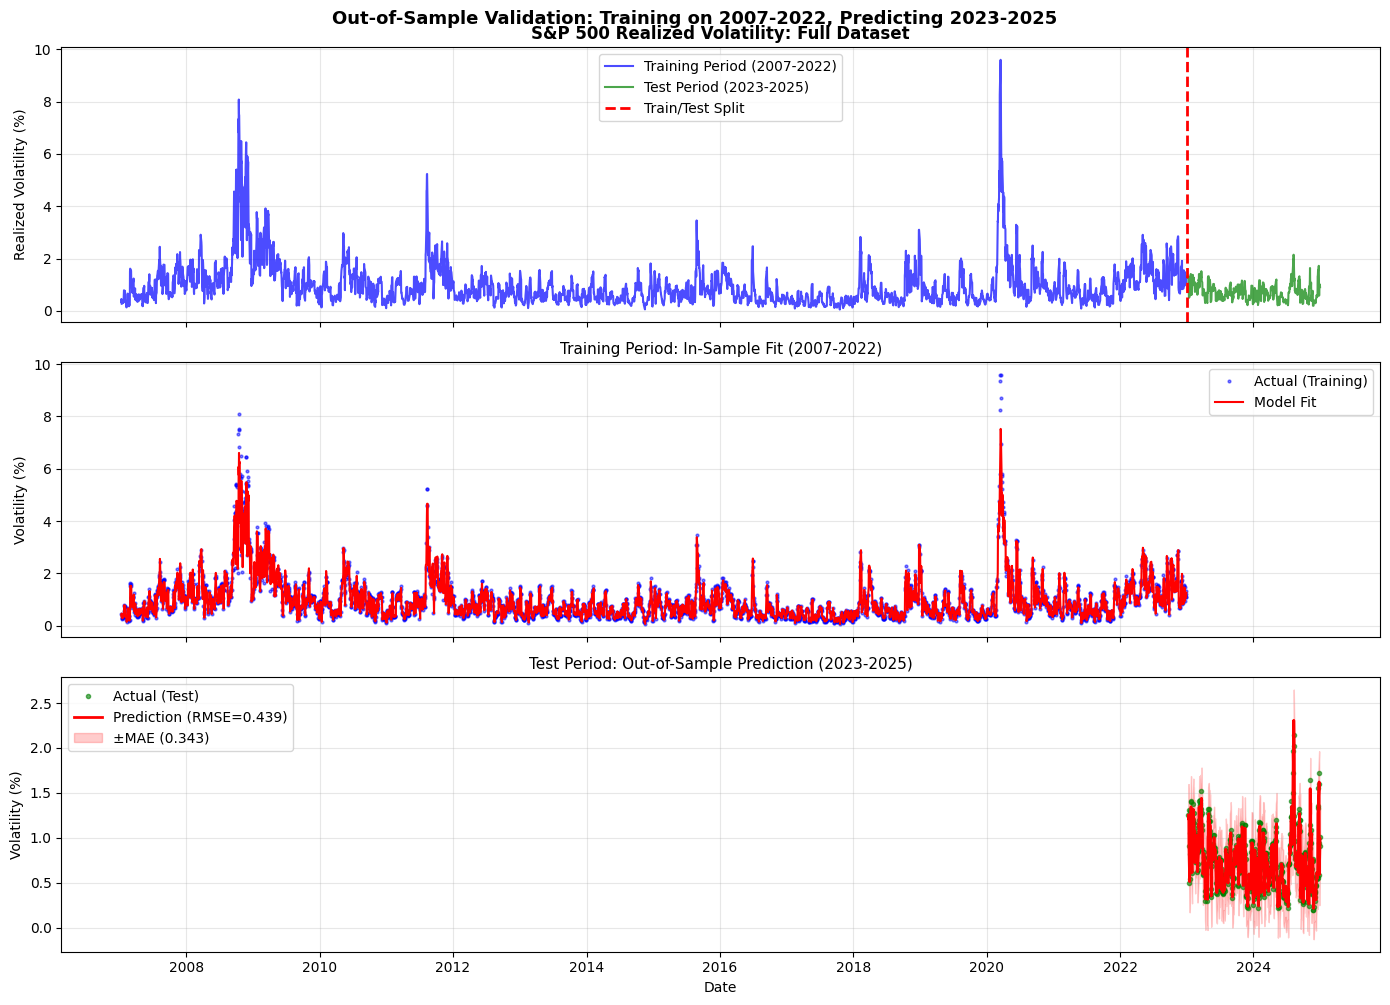


OUT-OF-SAMPLE PREDICTION PERFORMANCE
Root Mean Squared Error (RMSE): 0.4386
Mean Absolute Error (MAE):       0.3427
Mean Actual Volatility (Test):   0.7449
Relative RMSE (RMSE/Mean):       58.88%


In [6]:
import matplotlib.pyplot as plt

# Calculate prediction errors
rmse = np.sqrt(np.mean((vol_predicted - vol_actual)**2))
mae = np.mean(np.abs(vol_predicted - vol_actual))

# Plot
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Full time series (train + test)
ax[0].plot(dates_vol_train, realized_vol_train, color='blue', lw=1.5, label='Training Period (2007-2022)', alpha=0.7)
ax[0].plot(dates_vol_test, realized_vol_test, color='green', lw=1.5, label='Test Period (2023-2025)', alpha=0.7)
ax[0].axvline(pd.Timestamp('2022-12-31'), color='red', linestyle='--', lw=2, label='Train/Test Split')
ax[0].set_ylabel('Realized Volatility (%)')
ax[0].set_title('S&P 500 Realized Volatility: Full Dataset', fontsize=12, fontweight='bold')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Panel 2: Training Fit
with hierarchical_train:
    ppc_train = pm.sample_posterior_predictive(trace_train, random_seed=42)

fitted_train = ppc_train.posterior_predictive['obs'].mean(dim=['chain', 'draw']).values
vol_fitted_train = np.exp(fitted_train + np.mean(log_vol_train))

ax[1].plot(dates_vol_train[1:], realized_vol_train.values[1:], 'o', color='blue', 
           markersize=2, alpha=0.5, label='Actual (Training)')
ax[1].plot(dates_vol_train[1:], vol_fitted_train, color='red', lw=1.5, label='Model Fit')
ax[1].set_ylabel('Volatility (%)')
ax[1].set_title('Training Period: In-Sample Fit (2007-2022)', fontsize=11)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# Panel 3: Test Set Predictions
ax[2].plot(dates_vol_test[1:], vol_actual, 'o', color='green', markersize=3, 
           alpha=0.6, label='Actual (Test)', zorder=2)
ax[2].plot(dates_vol_test[1:], vol_predicted, color='red', lw=2, 
           label=f'Prediction (RMSE={rmse:.3f})', zorder=3)
ax[2].fill_between(dates_vol_test[1:], vol_predicted - mae, vol_predicted + mae, 
                   color='red', alpha=0.2, label=f'±MAE ({mae:.3f})')
ax[2].set_ylabel('Volatility (%)')
ax[2].set_xlabel('Date')
ax[2].set_title('Test Period: Out-of-Sample Prediction (2023-2025)', fontsize=11)
ax[2].legend()
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Out-of-Sample Validation: Training on 2007-2022, Predicting 2023-2025', 
             fontsize=13, fontweight='bold', y=1.00)
plt.show()

print("\n" + "="*60)
print("OUT-OF-SAMPLE PREDICTION PERFORMANCE")
print("="*60)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):       {mae:.4f}")
print(f"Mean Actual Volatility (Test):   {vol_actual.mean():.4f}")
print(f"Relative RMSE (RMSE/Mean):       {rmse/vol_actual.mean()*100:.2f}%")
print("="*60)


=== Data Verification ===
Test dates range: 2023-01-03 00:00:00 to 2024-12-31 00:00:00
Vol dates range: 2023-01-10 00:00:00 to 2024-12-31 00:00:00
Number of test points: 497
dates_plot shape: (497,)
vol_actual_flat shape: (497,)
vol_predicted_flat shape: (497,)


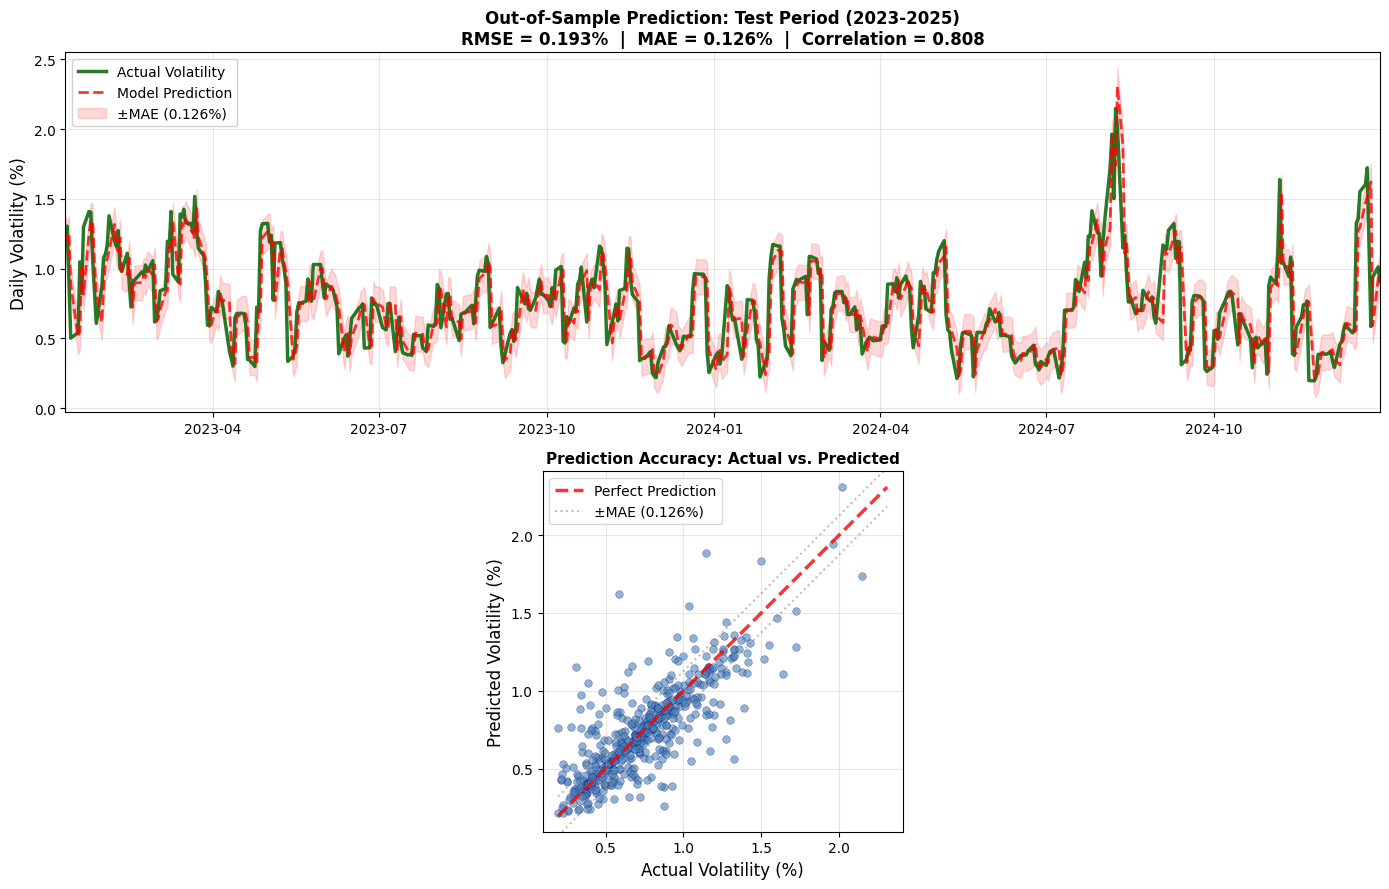


OUT-OF-SAMPLE VALIDATION: TEST PERIOD (2023-2025)

📊 PREDICTION ACCURACY METRICS:
  Root Mean Squared Error (RMSE):   0.1930%
  Mean Absolute Error (MAE):        0.1257%
  Relative RMSE (% of mean vol):    25.91%
  Pearson Correlation:              0.8076

📈 PREDICTION ERROR DISTRIBUTION:
  Mean Error (Bias):                -0.0052%
  Std. Dev of Errors:               0.1929%
  Max Overprediction:               +1.0364%
  Max Underprediction:              -0.7621%

🎯 DIRECTIONAL ACCURACY:
  Correct volatility direction:     251/496 (50.6%)

📌 BENCHMARK COMPARISON:
  Naive Persistence RMSE:           0.2015%
  Our Model RMSE:                   0.1930%
  Improvement over naive:           +4.2%

🔴 REGIME-SPECIFIC PERFORMANCE:
  Normal Regime (494 obs):      RMSE = 0.1923%
  Crisis Regime (3 obs):      RMSE = 0.2882%


In [7]:
# Flatten arrays to ensure they're 1D
vol_actual_flat = vol_actual.flatten()
vol_predicted_flat = vol_predicted.flatten()
regime_test_flat = regime_test.flatten()

# Define dates_plot properly
dates_plot = dates_vol_test[1:][:len(vol_actual_flat)]

# Recalculate metrics with flattened arrays
prediction_error = vol_predicted_flat - vol_actual_flat
rmse = np.sqrt(np.mean(prediction_error**2))
mae = np.mean(np.abs(prediction_error))

print("=== Data Verification ===")
print(f"Test dates range: {dates_test[0]} to {dates_test[-1]}")
print(f"Vol dates range: {dates_plot[0]} to {dates_plot[-1]}")
print(f"Number of test points: {len(vol_actual_flat)}")
print(f"dates_plot shape: {dates_plot.shape}")
print(f"vol_actual_flat shape: {vol_actual_flat.shape}")
print(f"vol_predicted_flat shape: {vol_predicted_flat.shape}")

# Create clean 2-panel plot
fig, axes = plt.subplots(2, 1, figsize=(14, 9))

# Panel 1: Time Series - Actual vs Predicted
axes[0].plot(dates_plot, vol_actual_flat, color='darkgreen', lw=2.5, 
             label='Actual Volatility', alpha=0.85)
axes[0].plot(dates_plot, vol_predicted_flat, color='red', lw=2, 
             label='Model Prediction', linestyle='--', alpha=0.8)
axes[0].fill_between(dates_plot, vol_predicted_flat - mae, vol_predicted_flat + mae, 
                     color='red', alpha=0.15, label=f'±MAE ({mae:.3f}%)')
axes[0].set_ylabel('Daily Volatility (%)', fontsize=12)
axes[0].set_title(f'Out-of-Sample Prediction: Test Period (2023-2025)\nRMSE = {rmse:.3f}%  |  MAE = {mae:.3f}%  |  Correlation = {np.corrcoef(vol_actual_flat, vol_predicted_flat)[0,1]:.3f}', 
                  fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10, framealpha=0.9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(dates_plot[0], dates_plot[-1])

# Panel 2: Scatter Plot - Actual vs Predicted
axes[1].scatter(vol_actual_flat, vol_predicted_flat, alpha=0.6, s=30, 
                c='steelblue', edgecolors='navy', linewidth=0.3)

# Add perfect prediction line
min_vol = min(vol_actual_flat.min(), vol_predicted_flat.min())
max_vol = max(vol_actual_flat.max(), vol_predicted_flat.max())
axes[1].plot([min_vol, max_vol], [min_vol, max_vol], 
             'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)

# Add ±MAE bands
axes[1].plot([min_vol, max_vol], [min_vol + mae, max_vol + mae], 
             'gray', linestyle=':', lw=1.5, alpha=0.5, label=f'±MAE ({mae:.3f}%)')
axes[1].plot([min_vol, max_vol], [min_vol - mae, max_vol - mae], 
             'gray', linestyle=':', lw=1.5, alpha=0.5)

axes[1].set_xlabel('Actual Volatility (%)', fontsize=12)
axes[1].set_ylabel('Predicted Volatility (%)', fontsize=12)
axes[1].set_title('Prediction Accuracy: Actual vs. Predicted', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, alpha=0.3)

# Force equal aspect for fair comparison
axes[1].set_xlim(min_vol - 0.1, max_vol + 0.1)
axes[1].set_ylim(min_vol - 0.1, max_vol + 0.1)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('out_of_sample_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed Diagnostics
print("\n" + "="*70)
print("OUT-OF-SAMPLE VALIDATION: TEST PERIOD (2023-2025)")
print("="*70)

print(f"\n📊 PREDICTION ACCURACY METRICS:")
print(f"  Root Mean Squared Error (RMSE):   {rmse:.4f}%")
print(f"  Mean Absolute Error (MAE):        {mae:.4f}%")
print(f"  Relative RMSE (% of mean vol):    {rmse/vol_actual_flat.mean()*100:.2f}%")
print(f"  Pearson Correlation:              {np.corrcoef(vol_actual_flat, vol_predicted_flat)[0,1]:.4f}")

print(f"\n📈 PREDICTION ERROR DISTRIBUTION:")
print(f"  Mean Error (Bias):                {prediction_error.mean():+.4f}%")
print(f"  Std. Dev of Errors:               {prediction_error.std():.4f}%")
print(f"  Max Overprediction:               {prediction_error.max():+.4f}%")
print(f"  Max Underprediction:              {prediction_error.min():+.4f}%")

# Directional accuracy
vol_changes_actual = np.diff(vol_actual_flat)
vol_changes_pred = np.diff(vol_predicted_flat)
correct_direction = np.sum((vol_changes_actual * vol_changes_pred) > 0)
total_changes = len(vol_changes_actual)
print(f"\n🎯 DIRECTIONAL ACCURACY:")
print(f"  Correct volatility direction:     {correct_direction}/{total_changes} ({correct_direction/total_changes*100:.1f}%)")

# Naive baseline
naive_forecast = vol_actual_flat[:-1]
naive_rmse = np.sqrt(np.mean((naive_forecast - vol_actual_flat[1:])**2))
improvement = (naive_rmse - rmse) / naive_rmse * 100
print(f"\n📌 BENCHMARK COMPARISON:")
print(f"  Naive Persistence RMSE:           {naive_rmse:.4f}%")
print(f"  Our Model RMSE:                   {rmse:.4f}%")
print(f"  Improvement over naive:           {improvement:+.1f}%")

# Regime analysis
if regime_test_flat.sum() > 0:
    rmse_normal = np.sqrt(np.mean((vol_predicted_flat[regime_test_flat==0] - vol_actual_flat[regime_test_flat==0])**2))
    rmse_crisis = np.sqrt(np.mean((vol_predicted_flat[regime_test_flat==1] - vol_actual_flat[regime_test_flat==1])**2))
    n_crisis = int(regime_test_flat.sum())
    n_normal = len(regime_test_flat) - n_crisis
    print(f"\n🔴 REGIME-SPECIFIC PERFORMANCE:")
    print(f"  Normal Regime ({n_normal} obs):      RMSE = {rmse_normal:.4f}%")
    print(f"  Crisis Regime ({n_crisis} obs):      RMSE = {rmse_crisis:.4f}%")
else:
    print(f"\n✅ NO CRISIS PERIODS in test set (all volatility < {threshold_train:.3f}%)")

print("="*70)


## Expanding window forecasting

Alignment Warning: Data len=498, Dates len=502
Truncating both to length 498 to prevent errors.
Forecasting 498 days using 12000 posterior samples...


/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_39057/3817486801.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  threshold = float(realized_vol_train.quantile(0.90))
/var/folders/kv/zt7j48t16bxdjlpfww8l32t00000gn/T/ipykernel_39057/3817486801.py:62: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  is_crisis = int(prev_realized_vol > threshold)


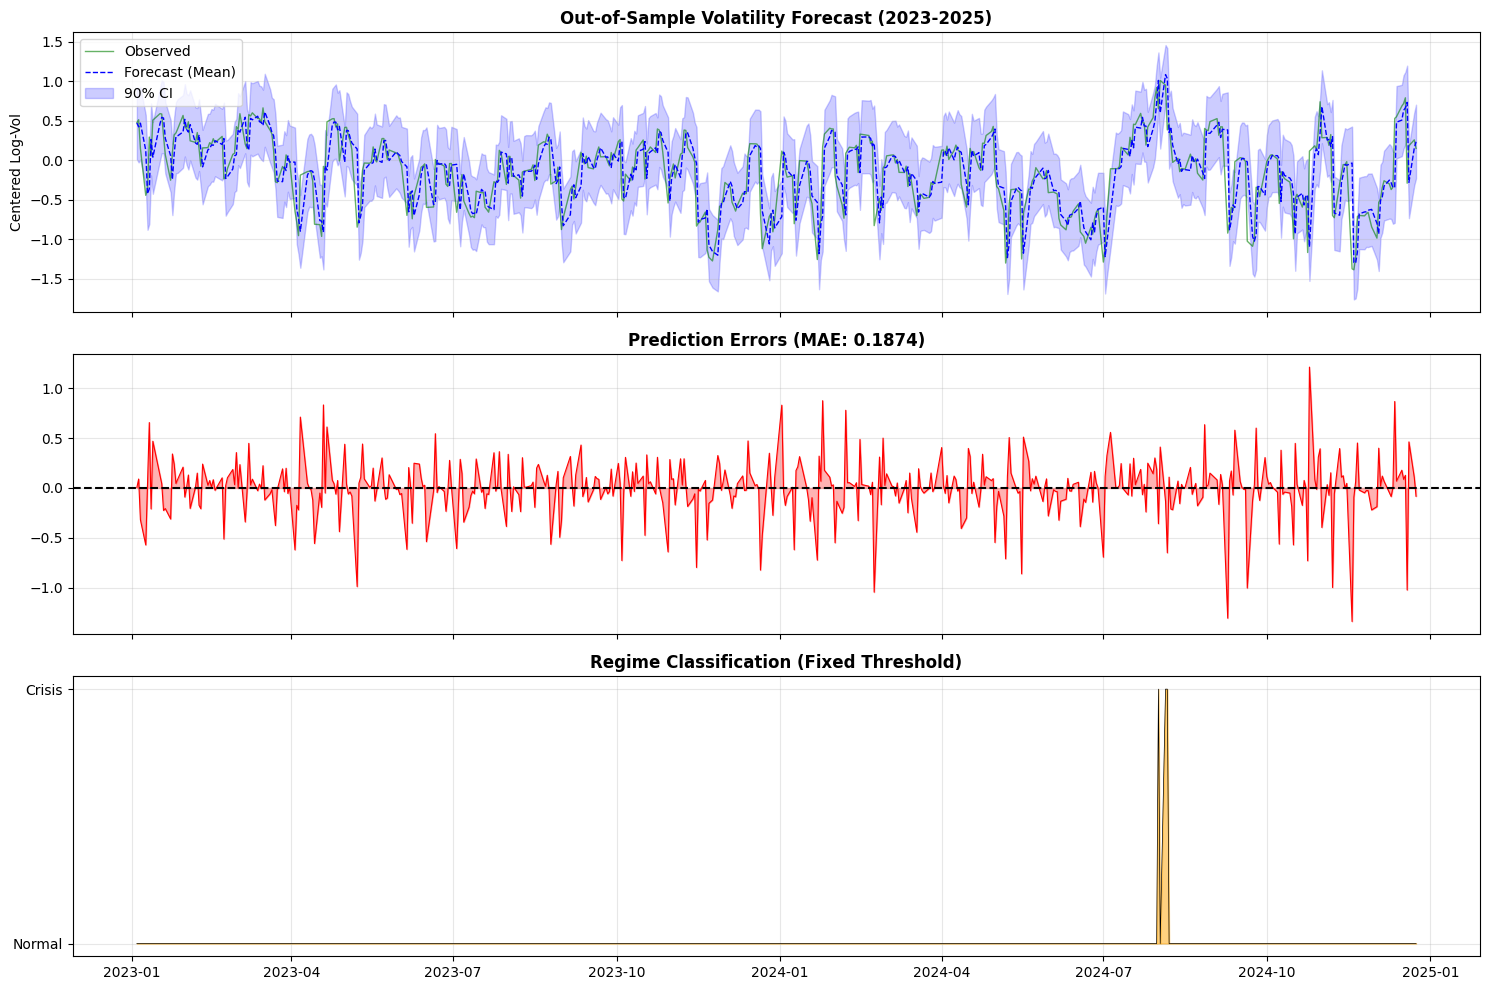

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def fixed_parameter_forecast(trace_train, log_vol_test, realized_vol_test, realized_vol_train, dates_test):
    """
    Forecasting using parameters learned from 2007-2022 (No Refitting).
    Includes automatic shape fixing and date alignment.
    """
    
    # --- 1. Fix Shapes & Alignments ---
    # Ensure inputs are 1D arrays
    log_vol_test = np.squeeze(log_vol_test)
    dates_test = np.array(dates_test)
    
    # Ensure lengths match exactly before starting
    min_len = min(len(log_vol_test), len(dates_test))
    if len(log_vol_test) != len(dates_test):
        print(f"Alignment Warning: Data len={len(log_vol_test)}, Dates len={len(dates_test)}")
        print(f"Truncating both to length {min_len} to prevent errors.")
        log_vol_test = log_vol_test[:min_len]
        dates_test = dates_test[:min_len]
        realized_vol_test = realized_vol_test.iloc[:min_len]
    
    n_test = len(log_vol_test)
    
    # --- 2. Extract Posterior Samples ---
    post = trace_train.posterior
    # Flatten chains
    mu_normal = post["mu_normal"].values.flatten()
    phi_normal = post["phi_normal"].values.flatten()
    sigma_normal = post["sigma_normal"].values.flatten()
    
    mu_crisis = post["mu_crisis"].values.flatten()
    phi_crisis = post["phi_crisis"].values.flatten()
    sigma_crisis = post["sigma_crisis"].values.flatten()
    
    nu = post["nu"].values.flatten()
    n_samples = len(mu_normal)

    # Threshold from training data
    threshold = float(realized_vol_train.quantile(0.90))
    
    # Storage
    forecasts_mean = np.zeros(n_test)
    forecasts_q05 = np.zeros(n_test)
    forecasts_q95 = np.zeros(n_test)
    regime_sequence = np.zeros(n_test)
    
    print(f"Forecasting {n_test} days using {n_samples} posterior samples...")
    
    # --- 3. Run Forecast Loop ---
    for t in range(n_test):
        if t == 0:
            continue # Skip first point (no lag available in this array)
            
        last_log_vol = log_vol_test[t-1]
            
        # Determine Regime (Using realized vol from t-1)
        prev_realized_vol = realized_vol_test.iloc[t-1]
        is_crisis = int(prev_realized_vol > threshold)
        regime_sequence[t] = is_crisis
        
        # Select parameters
        if is_crisis:
            mu, phi, sigma = mu_crisis, phi_crisis, sigma_crisis
        else:
            mu, phi, sigma = mu_normal, phi_normal, sigma_normal
            
        # Predictive Distribution
        expected_mu = mu + phi * last_log_vol
        preds = stats.t.rvs(df=nu, loc=expected_mu, scale=sigma, size=n_samples)
        
        forecasts_mean[t] = np.mean(preds)
        forecasts_q05[t] = np.percentile(preds, 5)
        forecasts_q95[t] = np.percentile(preds, 95)
        
    # --- 4. Return Aligned Results ---
    # Slice [1:] to remove the skipped first point
    return {
        'mean': forecasts_mean[1:],
        'q05': forecasts_q05[1:],
        'q95': forecasts_q95[1:],
        'observed': log_vol_test[1:],
        'regime': regime_sequence[1:],
        'dates': dates_test[1:] # Use the truncated/aligned dates
    }

# ==========================================
# EXECUTE
# ==========================================

# Run the forecast passing dates explicitly
results_fast = fixed_parameter_forecast(
    trace_train, 
    log_vol_test_centered, 
    realized_vol_test,
    realized_vol_train,
    dates_test # Pass this variable explicitly
)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# 1. Forecast vs Observed
axes[0].plot(results_fast['dates'], results_fast['observed'], 'g-', lw=1, alpha=0.6, label='Observed')
axes[0].plot(results_fast['dates'], results_fast['mean'], 'b--', lw=1, label='Forecast (Mean)')
axes[0].fill_between(results_fast['dates'], results_fast['q05'], results_fast['q95'], color='blue', alpha=0.2, label='90% CI')
axes[0].set_title('Out-of-Sample Volatility Forecast (2023-2025)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Centered Log-Vol')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Errors
errors = results_fast['observed'] - results_fast['mean']
axes[1].plot(results_fast['dates'], errors, 'r-', lw=0.8)
axes[1].axhline(0, color='k', linestyle='--')
axes[1].set_title(f'Prediction Errors (MAE: {np.mean(np.abs(errors)):.4f})', fontsize=12, fontweight='bold')
axes[1].fill_between(results_fast['dates'], 0, errors, color='red', alpha=0.3)
axes[1].grid(True, alpha=0.3)

# 3. Regimes
axes[2].plot(results_fast['dates'], results_fast['regime'], 'k-', lw=0.5)
axes[2].fill_between(results_fast['dates'], 0, results_fast['regime'], color='orange', alpha=0.5, label='Crisis Regime')
axes[2].set_title('Regime Classification (Fixed Threshold)', fontsize=12, fontweight='bold')
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Normal', 'Crisis'])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()